In [1]:
import csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from kiwipiepy import Kiwi, Match
from kiwipiepy.utils import Stopwords
from nltk.util import ngrams
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Titles_2024_Updated.csv')

In [3]:
texts = df['Title'].tolist()
texts = [str(text) for text in texts if isinstance(text, str) and text.strip() != "" and len(str(text).strip()) >= 5]

df['Publish Date'] = pd.to_datetime(df['Publish Date'])
df['Quarter'] = df['Publish Date'].dt.to_period('Q').astype(str)

/tmp/ipykernel_757446/2152349437.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Quarter'] = df['Publish Date'].dt.to_period('Q').astype(str)


In [4]:
# --- Initialize Kiwi and load user dictionary ONCE ---
kiwi = Kiwi(model_type='sbg')

user_words_to_add = [
    ("다이어", "NNP", -10.0),
    ("비카리오", "NNP", -10.0),
    ("잡식왕", "NNP", -10.0),
    ("김민선", "NNP", -10.0),
    ("신유빈", "NNP", -10.0),
    ("박항서", "NNP", -10.0),
    ("클린스만", "NNP", -10.0),
    ("아시안컵", "NNP", -10.0),
    ("조규성", "NNP", -10.0),
    ("이강인", "NNP", -10.0),
    ("안세영", "NNP", -10.0),
    ("김하성", "NNP", -10.0),
    ("윤성빈", "NNP", -10.0),
    ("모더나", "NNP", -10.0),
    ("로메로", "NNP", -10.0),
    ("오징어게임", "NNP", -10.0),
    ("지소미아", "NNP", -10.0),
    ("트루시에", "NNP", -10.0),
    ("톰크루즈", "NNP", -10.0),
    ("블랙핑크", "NNP", -10.0),
    ("K-POP", "NNG", -10.0),
    ("젓가락TV", "NNP", -10.0),
    ("초토화", "NNG", -10.0),
    ("요소수", "NNG", -10.0),
    ("한국화", "NNG", -10.0),
    ("시민의식", "NNG", -10.0),
    ("수원화성", "NNP", -10.0),
    ("믹스커피", "NNG", -10.0),
    ("초전도체", "NNG", -10.0),
    ("인공지능", "NNG", -10.0),
    ("문화유산", "NNG", -10.0),
    ("신기술", "NNG", -10.0),
    ("누리호", "NNP", -10.0),
    ("미스터션샤인", "NNP", -10.0)
]

for word, tag, score in user_words_to_add:
    try:
        kiwi.add_user_word(word, tag, score)
    except Exception as e:
        print(f"Failed to add word '{word}' ({tag}, {score}): {e}")
print(f"Added {len(user_words_to_add)} words to the user dictionary.")

stopwords = Stopwords()
user_stop_word = [
    "이유", "반응", "상황", "해외", "충격", "경악", "공개", "발표", "행동", "긴급",
    "처음", "최고", "외국", "폭발", "폭탄", "역대", "모습", "진짜", "최근", "안녕",
    "반전", "눈물", "소식", "장면", "추천", "생각", "실제", "극찬", "단독", "뜻밖",
    "난리", "속보", "영상", "비상", "정체", "참사", "감동", "당황", "사태", "기적",
    "파격", "소름", "모두", "결국", "근황", "기겁", "특집", "순간", "오열", "초유",
    "의외", "잡식", "한국", "한국인", "초토화", "실시간", "레전드", "끝판왕", "트래블튜브", "잡식왕",
    "TOP", "ft.", "Feat.", "xx"
]
user_stop_word_set = set(user_stop_word) # Convert to set for faster lookup

# --- Define the preprocessing function without dictionary loading ---
def preprocess_text(text, additional_stopwords=None):

    if additional_stopwords is None:
        additional_stopwords = set()

    # Ensure text is string for kiwi
    if not isinstance(text, str):
        text = str(text)

    tokens = kiwi.tokenize(text, normalize_coda=True, stopwords=stopwords)
    processed_text = [
        token.form
        for token in tokens
        if token.tag in ['NNG', 'NNP', 'SL']
        # and len(token.form) >= 2 # Uncomment if you want to re-enable this filter
        and token.form not in additional_stopwords
    ]
    return ' '.join(processed_text)

Added 34 words to the user dictionary.


In [5]:
df['Processed_Title'] = df['Title'].apply(lambda x: preprocess_text(x, additional_stopwords=set(user_stop_word)))

In [6]:
quarterly_word_counts = {}

for quarter in df['Quarter'].unique():
    quarter_texts = df[df['Quarter'] == quarter]['Processed_Title'].tolist()
    words = [word for text in quarter_texts for word in str(text).split()]
    word_counts = Counter(words)
    quarterly_word_counts[quarter] = word_counts

In [45]:
refined_quarterly_word_counts = {}

for quarter, counts in quarterly_word_counts.items():
    filtered_counts = Counter({word: count for word, count in counts.items() if count >= 10})
    refined_quarterly_word_counts[quarter] = filtered_counts

In [31]:
with open('Quarterly_Word_Counts_2024.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Quarter', 'Word', 'Count'])
    for quarter, counts in refined_quarterly_word_counts.items():
        for word, count in counts.most_common():  # You can limit this if you want
            writer.writerow([quarter, word, count])

In [7]:
topics_hierarchy = {
    #"Contemporary Culture": ["Music/K-pop", "Film/Television", "Performance"],
    #"Traditional Culture": ["Korean Food", "Korean Language", "Korean Clothing", "Korean Architecture"],
    "Culture": ["Music/Performance", "Film/Television", "Performance", "Food", "Language", "Clothing", "Architecture", "Heritage"],
    "Current Affairs": ["Company", "Economy", "Politics"],
    "Military": ["Military"],
    "Science/Technology": ["Semiconductor", "Automotive", "New Technology"],
    "Social Infrastructure": ["Public Order", "Medical System", "Public Facilities", "Public Transportation"],
    "Natural Environment": ["Animal/Plant", "River/Mountain", "Natural Disaster"],
    "Sports": ["Soccer", "Baseball", "Martial Arts", "Other Sports", "Olympics"]
    #"The Gaze of the Others": ["Authority Figures", "Celebrities", "Media Giants"]
}

subtopics = {
    "Music/Performance": ["pop", "BTS", "방탄소년단", "블랙핑크", "뉴진스", "르세라핌", "에스파", "차은우", "조수미", "케이팝", "아이돌", "걸그룹", "빌보드", "그래미", "공연", "관객", "무대", "공연장", "노래방", "명곡", "오디션", "참가자",
    "국악", "아리랑", "가야금", "해금", "피아니스트", "오케스트라"],
    "Film/Television": ["영화", "드라마", "예능", "오징어게임", "넷플릭스", "봉준호", "예고편", "부산행", "글로리", "글로브", "아카데미", "윤여정", "사극", "우영우", "이정재", "이병헌", "송강호", "파묘"],
    #"Performance": ["공연", "관객", "무대", "공연장", "오디션", "참가자", "군악대", "피아니스트", "오케스트라"],
    "Food": ["한식", "음식", "급식", "김치", "김치전", "밥상", "치킨", "김밥", "비빔밥", "불고기", "떡볶이", "떡볶이집", "라면", "삼겹살", "셰프", "불닭볶음면", "한우", "소주", "막걸리", "한정식", "식당", "미식가", "도시락", "맛집", "간식", "식사", "음식점", "고기",
    "전통주", "물냉면", "냉면", "홍삼", "갈비찜", "튀김우동", "파김치", "삼계탕", "묵은지", "장어", "쌈밥", "짜파게티", "곤드레", "명태", "계란빵", "홍시", "꼬막", "시래기", "호두과자", "송편", "백종원", "김치볶음밥", "요리", "요리사", "곰탕", "포장마차", "믹스커피",
    "육회", "낙지", "곱창", "소맥", "마늘", "디저트", "밀키스", "호떡", "미슐랭", "아이스크림", "족발", "짜장면", "국밥", "갈비", "소갈비찜", "횟집", "고추장", "김치찌개", "청국장", "붕어빵", "먹방", "군고구마", "과메기", "반찬", "제육볶음", "핫도그", "밥도둑", "쉐프"] ,
    "Language": ["한글", "한국어", "한국말", "훈민정음"],
    "Clothing": ["한복"],
    "Architecture": ["한옥", "온돌", "마루", "궁전", "경복궁", "수원화성", "건축물", "건축가"],
    "Heritage": ["문화재", "문화유산", "유물", "유적지", "유네스코", "나전칠기", "조선왕조실록"],
    "Company": ["기업", "중소기업", "파산", "삼성", "삼성전자", "LG", "현대", "애플", "구글", "TSMC", "인텔", "엔비디아", "테슬라", "화웨이"],
    "Economy": ["경제", "무역", "수입", "수출", "관세", "은행", "엔화", "달러", "인플레이션", "요소수", "IMF", "WTO"],
    "Politics": ["트럼프", "바이든", "푸틴", "시진핑", "아베", "기시다", "스가", "김정은", "공산당", "공화당", "민주당", "대선", "계엄령", "비상계엄", "민주주의", "탄핵"],
    "Semiconductor": ["반도체", "파운드리", "메모리", "TSMC"],
    "New Technology": ["신기술", "신소재", "초전도체", "누리호", "드론쇼", "배터리"],
    "Automotive": ["자동차", "현대차", "현대자동차", "현대기아", "기아", "도요타", "테슬라", "벤츠", "닛산", "폭스바겐", "포르쉐", "벤틀리", "아반떼", "모터쇼"],
    "Military": ["미군", "한국군", "부대", "군인", "예비군", "해병대", "특전사", "군대", "여군", "장교", "인민군", "부대원", "특수부대", "군복", "병사", "육군", "해군", "공군", "나토", "무기", "전차", "방산", "방위", "KF", "전투기", "자위대", "군사력", "림팩",
    "보잉", "록히드마틴", "이지스함", "KFX", "AESA", "SLBM", "UDT", "SEAL", "SAR", "NATO", "지소미아", "스텔스기", "전투력", "탱크", "소총", "곡사포", "잠수함", "보병", "전투", "자주포", "발포", "주한미군", "탄약", "미사일", "격추", "레이더", "천무", "현무",
    "흑표", "화포", "무장", "국방", "군함", "무인기", "헬기", "구축함", "군사", "CVX", "MRO", "LNG", "K2", "KDDX", "NLAW", "포탑", "방공", "함대", "로켓", "무인기", "이지스", "스텔스", "핵무장", "핵무기", "국방부", "L-SAM", "포탄", "파병", "항모"],
    "Public Order": ["치안", "질서", "밤길", "경찰", "범죄자"],
    "Medical System": ["병원", "의료", "의료진", "간호사", "의사", "백신", "방역", "수술", "치과", "약국", "병원비", "치료", "치료제", "보건", "FDA", "구급차"],
    "Public Facilities": ["화장실", "공중화장실", "휴게소", "공항", "인천공항", "공원", "도서관", "찜질방", "마트", "편의점", "수돗물"],
    "Public Transportation": ["대중교통", "지하철", "버스", "고속버스", "심야버스", "정류장"],
    "Animal/Plant": ["진돗개", "토종", "외래종", "야생동물", "생명체"],
    "River/Mountain": ["한강", "설악산", "북한산", "한라산", "등산", "등산로", "산악인"],
    "Natural Disaster": ["지진", "태풍", "폭설", "폭우", "쓰나미", "화산", "날씨"],
    "Soccer": ["축구", "토트넘", "손흥민", "케인", "맨시티", "아스날", "아스널", "리버풀", "맨유", "해트트릭", "바이에른", "김민재", "황희찬", "PSG", "이강인", "박항서", "신태용", "김판곤", "월드컵", "EPL", "발롱도르", "축협", "벤투", "메시", "호날두", "음바페",
    "포스테코글루", "콘테", "무리뉴", "엔리케", "포체티노", "네이마르", "매디슨", "박지성", "차범근", "투헬", "다이어", "페리시치", "히샬리송", "아시안컵", "EPL", "프리미어리그", "황의조", "황선홍", "홍명보", "프리킥", "요리스", "쏘니", "호이비에르", "자책골", "오현규",
    "박항서", "축구협회", "SON", "로메로", "비카리오", "클린스만", "이영표", "안정환", "유벤투스"],
    "Baseball": ["야구", "야구장", "류현진", "김하성", "이정후", "김혜성", "배지환", "푸이그", "니퍼트", "뷰캐넌", "메이저리그", "MLB", "홈런", "투수", "타자", "다저스", "출루", "오타니", "다저스"],
    "Martial Arts": ["태권도", "택견", "씨름", "태권도장", "가라테", "가라데", "UFC"],
    "Other Sports": ["배구", "양궁", "쇼트트랙", "탁구", "배드민턴", "피겨", "김연아", "김연경", "최민정", "심석희", "신유빈", "김민선", "이상화", "윤성빈", "차준환", "안세영", "장미란", "스노보드", "금메달", "은메달", "동메달", "계주", "빙상"],
    "Olympics": ["올림픽", "IOC", "선수촌"],
    # "Authority Figures": ["명문대", "교수", "노벨", "노벨상", "하버드", "석학", "전문가"],
    # "Celebrities": ["연예인", "헐리웃", "헐리우드", "할리우드", "헐리웃배우", "헐리웃배우의" "톱스타", "탑스타", "스타", "여배우"],
    # "Media Giants": ["BBC", "CNN", "뉴욕타임즈", "뉴욕타임스"]
}

countries = {
    "Japan": ["일본", "일본인", "일본어", "日", "자위대", "아베", "아베노", "기시다", "스가", "도쿄", "교토", "후지산", "대마도", "후쿠시마", "오키나와", "오사카", "열도", "독도", "한일", "한일전", "도요타", "욱일기", "유니클로", "재팬", "엔화", "스시녀"],
    "China": ["중국", "중국인", "중국어", "중국군", "中", "시진핑", "베이징", "상하이", "톈진", "우한", "한중", "한중전", "사드", "홍콩", "화웨이", "환구시보", "화교", "차이나타운", "마윈", "탕웨이", "천위페이", "조선족", "소림축구", "위완화", "천안문", "리커창", "남중국해", "싼샤"],
    "USA": ["미국", "미국인", "미군", "美", "백악관", "트럼프", "바이든", "바이든에", "오바마", "해리스", "펠로시", "뉴욕", "LA", "보스턴"],
    "UK": ["영국", "영국인", "영국군", "英", "스코틀랜드", "웨일스", "웨일즈", "런던"],
    "Vietnam": ["베트남", "베트남인", "베트남전", "하노이", "다낭"],
    "Russia": ["러시아", "러시아인", "러시아군", "러군", "푸틴", "모스크바", "바그너", "쿠릴열도"],
    "Germany": ["독일", "독일인", "독일군", "베를린", "메르켈"],
    "Taiwan": ["대만", "대만인", "대만해협", "TSMC"],
    "France": ["프랑스", "프랑스인", "마크롱", "파리", "파리지앵", "루브르", "세느강"],
    "Poland": ["폴란드", "폴란드인"],
    "Ukraine": ["우크라이나", "우크라", "우크라이나인", "젤렌스키", "키예프", "키이우", "마리우폴", "헤르손", "돈바스", "바흐무트"],
    "North Korea": ["북한", "북한사람", "북한인", "북한군", "北", "탈북", "탈북자", "탈북민", "김정일", "김정은", "평양", "기쁨조"],
    "India": ["인도", "인도인", "인도유튜버", "뭄바이", "푸니타"],
    "Indonesia": ["인도네시아", "인니", "자카르타"],
    "Australia": ["호주", "호주인", "시드니"],
    "Canada": ["캐나다", "캐나다인", "퀘벡", "트뤼도"],
    "Brazil": ["브라질"],
    "Italy": ["이탈리아", "이태리", "이탈리아인", "나폴리", "로마"],
    "Qatar": ["카타르", "카타르인"],
    "Myanmar": ["미얀마", "미얀마인", "흘라잉"],
    "Spain": ["스페인", "스페인인", "서반아"],
    "Saudi Arabia": ["사우디아라비아", "사우디", "빈살만"],
    "Philippines": ["필리핀", "필리핀인", "필리핀군", "두테르테", "마닐라", "민다나오"],
    "Thailand": ["태국", "태국인", "태국군"],
    "Israel": ["이스라엘", "이스라엘군", "유대인", "유태인", "네타냐후", "텔아비브"],
    "Iran": ["이란", "이란전", "테헤란"],
    "Turkey": ["터키", "튀르키예", "터키인", "에르도안", "이스탄불"],
    "Afghanistan": ["아프가니스탄", "아프간", "카불"],
    "Egypt": ["이집트", "이집트인", "수에즈"],
    "UAE": ["UAE", "아랍에미리트", "두바이", "아부다비"],
    "Netherlands": ["네덜란드", "네덜란드인", "암스테르담"],
    "Norway": ["노르웨이", "노르웨이인", "노르웨이군"],
    "Uruguay": ["우루과이", "우루과이전"],
    "Mongolia": ["몽골", "몽골족"],
    "Mexico": ["멕시코", "멕시코인"],
    "Finland": ["핀란드", "핀란드인"],
    "Sweden": ["스웨덴", "스웨덴인"],
    "Argentina": ["아르헨티나", "아르헨티나인", "아르헨"],
    "Switzerland": ["스위스", "스위스인", "알프스"],
    "Ghana": ["가나", "가나인", "가나전"],
    "Portugal": ["포르투갈", "포르투칼", "포르투갈인", "리스본"],
    "Uzbekistan": ["우즈베키스탄", "우즈벡"],
    "Kazakhstan": ["카자흐스탄", "카자흐"],
    "Belgium": ["벨기에", "벨기에인"],
    "Tunisia": ["튀니지"],
    "Hungary": ["헝가리", "헝가리인"],
    "Colombia": ["콜롬비아"],
    "Romania": ["루마니아"],
    "New Zealand": ["뉴질랜드"],
    "Malaysia": ["말레이시아", "말레이"],
    "Singapore": ["싱가포르", "싱가포르전", "싱가포르항", "싱가폴"],
    "Iraq": ["이라크"],
    "Sri Lanka": ["스리랑카"],
    "Nigeria": ["나이지리아"],
    "Denmark": ["덴마크", "덴마크인"],
    "Cambodia": ["캄보디아"],
    "Czechia": ["체코"],
    "Chile": ["칠레", "칠레전", "산티아고"],
    "Peru": ["페루"],
    "Syria": ["시리아"],
    "Pakistan": ["파키스탄"],
    "Azerbaijan": ["아제르바이잔", "아제르바이젠", "아제르"],
    "Belarus": ["벨라루스"],
    "Lebanon": ["레바논", "레바논전"],
    "Venezuela": ["베네수엘라"],
    #---no.20---#
    "Croatia": ["크로아티아"],
    "Greece": ["그리스", "아테네"],
    "Bangladesh": ["방글라데시", "방글라"],
    "Austria": ["오스트리아", "오스트리아인"],
    "Iceland": ["아이슬란드"],
    "South Africa": ["남아공"],
    "Kenya": ["케냐"],
    "Jordan": ["요르단"],
    "Syria": ["시리아", "시리아전"],
    "Yemen": ["예멘"],
    "Angola": ["앙골라"],
    "Ethiopia": ["에티오피아"],
    "Liberia": ["라이베리아"],
    "Ireland": ["아일랜드"],
    "Bulgaria": ["불가리아"],
    "Laos": ["라오스"],
    "Nepal": ["네팔", "네팔인"],
    "Maldives": ["몰디브"],
    "Paraguay": ["파라과이"],
    "Bolivia": ["볼리비아"],
    "Ecuador": ["에콰도르"],
    "Guatemala": ["과테말라"],
    "Honduras": ["온두라스"],
    "Cuba": ["쿠바"],
    "Kyrgyzstan": ["키르기스스탄", "키르기즈스탄"],
    "Turkmenistan": ["투르크메니스탄"],
    "Bahrain": ["바레인"],
    "Kuwait": ["쿠웨이트", '쿠웨이트전'],
    "Morocco": ["모로코"],
    "Estonia": ["에스토니아"],
    "Lithuania": ["리투아니아"],
    "Moldova": ["몰도바"],
    "Serbia": ["세르비아"],
    "Slovakia": ["슬로바키아"],
    "North Macedonia": ["마케도니아"],
    "Senegal": ["세네갈"],
    "Haiti": ["아이티"],
    "Jamaica": ["자메이카"],
    "El Salvador": ["엘살바도르"],
    "Vatican": ["바티칸"],
    "Luxembourg": ["룩셈부르크"],
    "Algeria": ["알제리"],
    "Libya": ["리비아"],
    "Somalia": ["소말리아"],
    "Uganda": ["우간다"],
    "Tanzania": ["탄자니아"],
    "Benin": ["베냉"],
    "Botswana": ["보츠와나"],
    "Rwanda": ["르완다"],
    "Ivory Coast": ["코트디부아르"],
    "Madagascar": ["마다가스카르"],
    "Malawi": ["말라위"],
    "Mozambique": ["모잠비크"],
    "DRC": ["콩고"],
    "Gabon": ["가봉"],
    "Zambia": ["잠비아"],
    "Zimbabwe": ["짐바브웨"],
    "Dominica Republic": ["도미니카"],
    "Papua New Guinea": ["파푸아뉴기니"],
    "Tonga": ["통가"]
    #---Continents---#
    # "Europe": ["유럽", "유럽인", "서유럽", "동유럽", "북유럽", "남유럽"],
    # "South America": ["남미", "남미인", "중남미"],
    # "Middle East": ["중동", "아랍", "아랍인"],
    # "Africa": ["아프리카", "아프리카인"], 
}

In [8]:
def annotate_title(title, subtopics_dict, topics_hierarchy, countries_dict):
    title_subtopics = set()
    title_countries = set()

    for word in title.split():
        for subtopic, keywords in subtopics_dict.items():
            if word in keywords:
                title_subtopics.add(subtopic)
        for country, keywords in countries_dict.items():
            if word in keywords:
                title_countries.add(country)
    
    title_topics = set()
    for subtopic in title_subtopics:
        for topic, subtopic_list in topics_hierarchy.items():
            if subtopic in subtopic_list:
                title_topics.add(topic)

    return list(title_topics), list(title_subtopics), list(title_countries)

In [9]:
annotations = df['Processed_Title'].apply(
    lambda title: pd.Series(annotate_title(title, subtopics, topics_hierarchy, countries))
)

# Split the annotations into separate columns
df['Topics'], df['Subtopics'], df['Country Mentions'] = annotations[0], annotations[1], annotations[2]

In [10]:
# Initialize a dictionary to count occurrences of each subtopic
subtopic_counts = {}

# Iterate over the list of subtopics in each row of the DataFrame
for subtopics in df['Subtopics']:
    for subtopic in subtopics:
        if subtopic in subtopic_counts:
            subtopic_counts[subtopic] += 1
        else:
            subtopic_counts[subtopic] = 1

# Print the count of documents per subtopic
print(subtopic_counts)

{'Food': 2818, 'River/Mountain': 135, 'Company': 1670, 'Film/Television': 1158, 'Politics': 1999, 'Public Transportation': 377, 'Architecture': 113, 'Military': 5346, 'Public Order': 230, 'Heritage': 102, 'Medical System': 609, 'Public Facilities': 848, 'New Technology': 195, 'Automotive': 347, 'Music/Performance': 1132, 'Soccer': 4966, 'Other Sports': 756, 'Olympics': 789, 'Economy': 1062, 'Language': 566, 'Martial Arts': 226, 'Baseball': 579, 'Natural Disaster': 395, 'Animal/Plant': 199, 'Clothing': 123, 'Semiconductor': 347}


In [11]:
# Initialize a dictionary to count occurrences of each subtopic
country_counts = {}

# Iterate over the list of subtopics in each row of the DataFrame
for countries in df['Country Mentions']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Print the count of documents per subtopic
print(country_counts)

{'Japan': 10847, 'China': 7107, 'Thailand': 244, 'USA': 7361, 'Italy': 387, 'Germany': 979, 'North Korea': 737, 'Cambodia': 22, 'Mongolia': 90, 'Israel': 142, 'Hungary': 44, 'France': 1061, 'UK': 2190, 'Sweden': 110, 'Taiwan': 635, 'India': 388, 'Indonesia': 606, 'Russia': 1241, 'Pakistan': 35, 'Saudi Arabia': 251, 'Canada': 277, 'Vietnam': 742, 'Ethiopia': 11, 'Myanmar': 126, 'Spain': 198, 'Iran': 111, 'Ukraine': 408, 'Philippines': 172, 'Australia': 361, 'Switzerland': 79, 'UAE': 135, 'Norway': 97, 'New Zealand': 40, 'Romania': 86, 'Poland': 696, 'Croatia': 5, 'Mexico': 75, 'Brazil': 201, 'Qatar': 235, 'Netherlands': 116, 'Czechia': 40, 'Argentina': 60, 'Egypt': 102, 'Turkey': 207, 'Afghanistan': 94, 'Kazakhstan': 29, 'Iraq': 47, 'Jordan': 37, 'Lebanon': 13, 'Singapore': 84, 'Malaysia': 130, 'Bahrain': 26, 'Senegal': 13, 'Tunisia': 25, 'Uzbekistan': 53, 'Kuwait': 12, 'Greece': 22, 'Nigeria': 22, 'Finland': 89, 'Portugal': 42, 'Ghana': 41, 'Sri Lanka': 31, 'Paraguay': 6, 'Chile': 24, 

In [12]:
# Convert the country_counts dictionary to a DataFrame
country_df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Count'])

sorted_country_df = country_df.sort_values(by='Count', ascending=False)

# Display the sorted DataFrame
pd.set_option('display.max_rows', None)
sorted_country_df

,Country,Count
0,Japan,10847
3,USA,7361
1,China,7107
12,UK,2190
17,Russia,1241
11,France,1061
5,Germany,979
21,Vietnam,742
6,North Korea,737
34,Poland,696


In [44]:
# Explode the DataFrame by 'Country Mentions' to separate each country into its own row
df_exploded = df.explode('Country Mentions')

# Group by 'Country Mentions' and aggregate topics and subtopics
country_topic_counts = df_exploded.groupby('Country Mentions').Topics.apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)
# country_subtopic_counts = df_exploded.groupby('Country Mentions').Subtopics.apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)

# # Combine the counts into a single DataFrame for better readability
# country_aggregated_data = country_topic_counts.join(country_subtopic_counts, lsuffix='_Topics', rsuffix='_Subtopics')

# country_aggregated_data.to_csv('country_aggregated_data.csv', index=True)

# # Display the aggregated data
# country_aggregated_data
country_topic_counts

,Culture,Current Affairs,Military,Natural Environment,Science/Technology,Social Infrastructure,Sports
Country Mentions,,,,,,,
Afghanistan,2,6,26,1,0,2,1
Algeria,0,0,1,0,0,1,0
Angola,0,0,1,0,0,1,0
Argentina,9,3,4,2,1,3,20
Australia,36,30,92,6,3,13,42
Austria,3,1,0,0,0,1,1
Azerbaijan,3,0,1,0,0,3,1
Bahrain,0,0,1,0,0,1,16
Bangladesh,0,2,1,0,0,1,2


In [45]:
# Group by 'Country Mentions' and aggregate topics
country_topics = df_exploded.groupby('Country Mentions').Topics.apply(lambda x: x.explode().value_counts()).reset_index(name='Count')
country_topics
country_topics['Topic_Counts'] = country_topics['level_1'] + ' [' + country_topics['Count'].astype(str) + ']'

# Aggregate these counts into a single string per country
formatted_topics = country_topics.groupby('Country Mentions').Topic_Counts.apply(lambda x: '; '.join(x)).reset_index(name='Topics')

formatted_topics.to_csv('formatted_topics_2024.csv', index=True)

# Display the formatted DataFrame
formatted_topics

,Country Mentions,Topics
0,Afghanistan,Military [26]; Current Affairs [6]; Culture [2...
1,Algeria,Military [1]; Social Infrastructure [1]
2,Angola,Social Infrastructure [1]; Military [1]
3,Argentina,Sports [20]; Culture [9]; Military [4]; Curren...
4,Australia,Military [92]; Sports [42]; Culture [36]; Curr...
5,Austria,Culture [3]; Social Infrastructure [1]; Curren...
6,Azerbaijan,Social Infrastructure [3]; Culture [3]; Sports...
7,Bahrain,Sports [16]; Social Infrastructure [1]; Milita...
8,Bangladesh,Current Affairs [2]; Sports [2]; Social Infras...
9,Belarus,Military [12]; Current Affairs [5]; Social Inf...


In [46]:
# Rename the 'Country Mentions' column in formatted_topics to 'Country' to match sorted_country_df
formatted_topics.rename(columns={'Country Mentions': 'Country'}, inplace=True)

# Merge formatted_topics into sorted_country_df based on the 'Country' column
# Ensure that both dataframes have a 'Country' column for the merge
merged_df = sorted_country_df.merge(formatted_topics[['Country', 'Topics']], on='Country', how='left')

merged_df.to_csv('merged_df_2024.csv', index=True)

# Display the merged DataFrame
merged_df

,Country,Count,Topics
0,Japan,10847,Current Affairs [1628]; Sports [1274]; Culture...
1,USA,7361,Current Affairs [1248]; Culture [1150]; Milita...
2,China,7107,Current Affairs [1104]; Military [1058]; Sport...
3,UK,2190,Sports [918]; Culture [249]; Military [124]; S...
4,Russia,1241,Current Affairs [416]; Military [385]; Culture...
5,France,1061,Sports [263]; Culture [182]; Military [114]; S...
6,Germany,979,Military [188]; Culture [110]; Sports [92]; Cu...
7,Vietnam,742,Sports [223]; Current Affairs [124]; Social In...
8,North Korea,737,Military [191]; Current Affairs [159]; Culture...
9,Poland,696,Military [439]; Current Affairs [60]; Culture ...


In [10]:
file_path = 'Annotated_Titles_2024.csv'
df.to_csv(file_path, index=False, encoding='utf-8-sig')

In [14]:
unlabeled_entries = df[(df['Topics'].str.len() == 0) & (df['Subtopics'].str.len() == 0) & (df['Country Mentions'].str.len() == 0)]

unlabeled_file_path = 'Unlabeled_Entries_2024.csv'

unlabeled_entries.to_csv(unlabeled_file_path, index=False, encoding='utf-8-sig')

In [13]:
expanded_df = df.explode('Topics')
topic_counts_by_quarter = expanded_df.groupby(['Quarter', 'Topics']).size().reset_index(name='Count')
pivot_counts_df = topic_counts_by_quarter.pivot(index='Quarter', columns='Topics', values='Count').fillna(0)
pivot_counts_df = pivot_counts_df[pivot_counts_df.index >= '2019Q1']

In [14]:
topics_by_quarter = df.groupby('Quarter')['Topics'].apply(np.sum).reset_index()

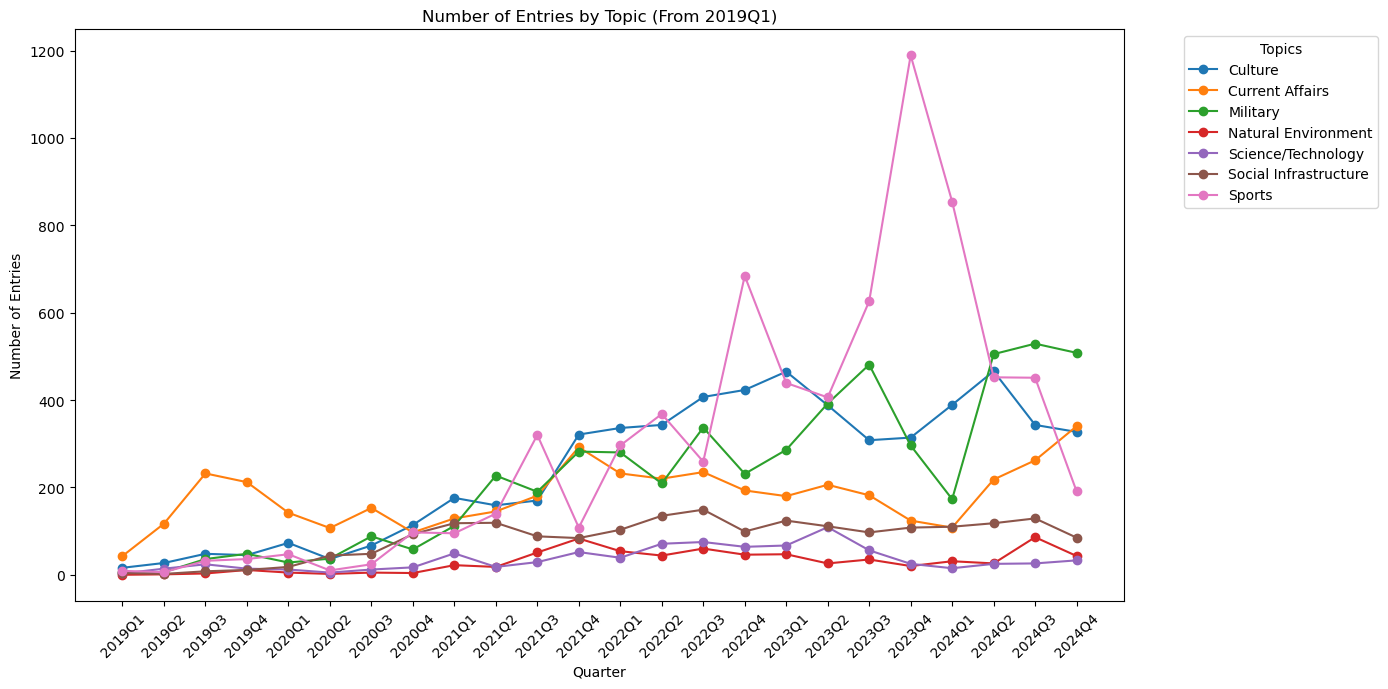

In [17]:
plt.figure(figsize=(14, 7))
# Loop through the columns (topics) to plot each as a separate line
for column in pivot_counts_df.columns:
    y_data = pivot_counts_df[column].values  # Converts to a NumPy array
    x_data = pivot_counts_df.index.values  # Converts index to a NumPy array
    plt.plot(x_data, y_data, marker='o', label=column)

plt.title('Number of Entries by Topic (From 2019Q1)')
plt.xlabel('Quarter')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')  # Optionally place legend outside the plot
plt.grid(False)  # Add grid for easier reading
plt.tight_layout()
plt.show()

In [18]:
topics_percentage_df = pd.DataFrame()
for index, row in topics_by_quarter.iterrows():
    quarter = row['Quarter']
    topics_list = row['Topics']
    topics_count = Counter(topics_list)
    total_mentions = sum(topics_count.values())
    for topic, count in topics_count.items():
        temp_df = pd.DataFrame({
            'Quarter': [quarter],
            'Topic': [topic],
            'Percentage': [(count / total_mentions) * 100]
        })
        topics_percentage_df = pd.concat([topics_percentage_df, temp_df], ignore_index=True)

In [19]:
pivot_df = topics_percentage_df.pivot(index='Quarter', columns='Topic', values='Percentage')

filtered_pivot_df = pivot_df[pivot_df.index >= '2019Q1']

filtered_pivot_df.fillna(0, inplace=True)

/tmp/ipykernel_272038/3588402842.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pivot_df.fillna(0, inplace=True)


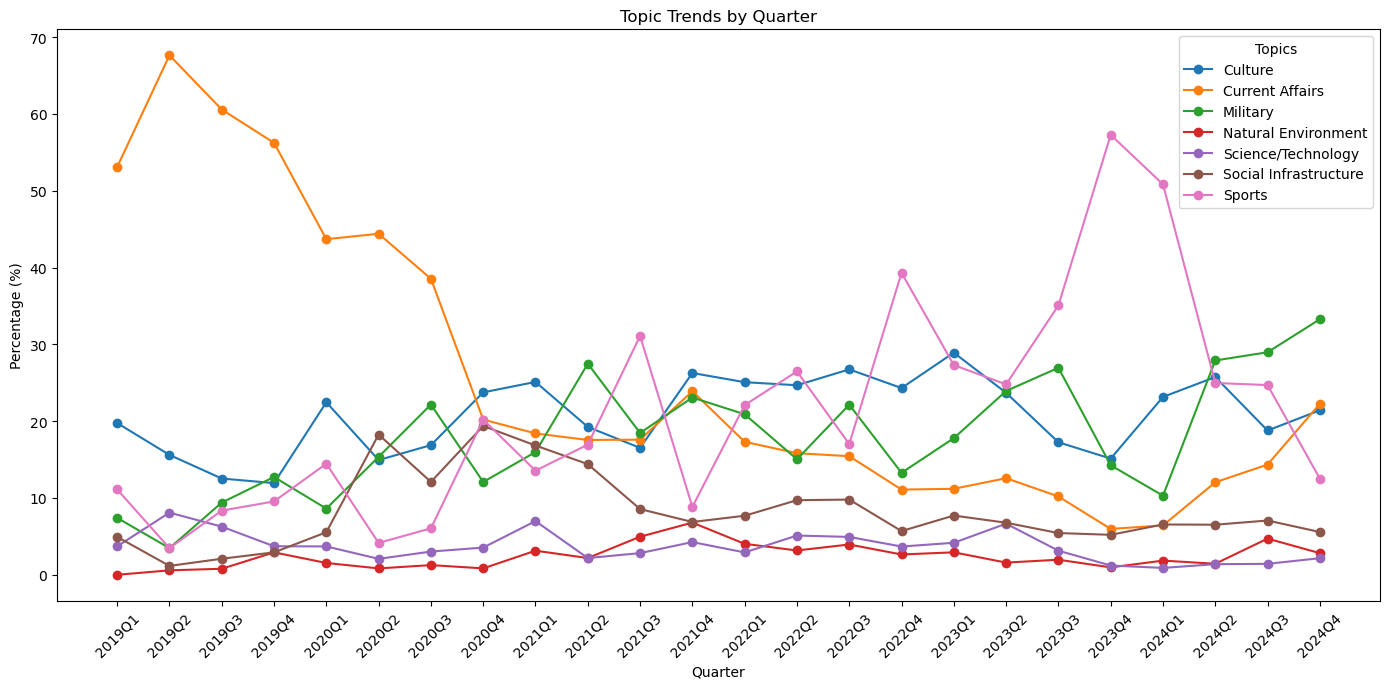

In [20]:
plt.figure(figsize=(14, 7))

# Loop through the columns (topics) to plot each as a separate line
for column in filtered_pivot_df.columns:
    y_data = filtered_pivot_df[column].values  # Convert Series to NumPy array
    x_data = filtered_pivot_df.index.values  # Convert index to NumPy array
    plt.plot(x_data, y_data, marker='o', label=column)

plt.title('Topic Trends by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Topics')
plt.grid(False)
plt.tight_layout()
plt.show()


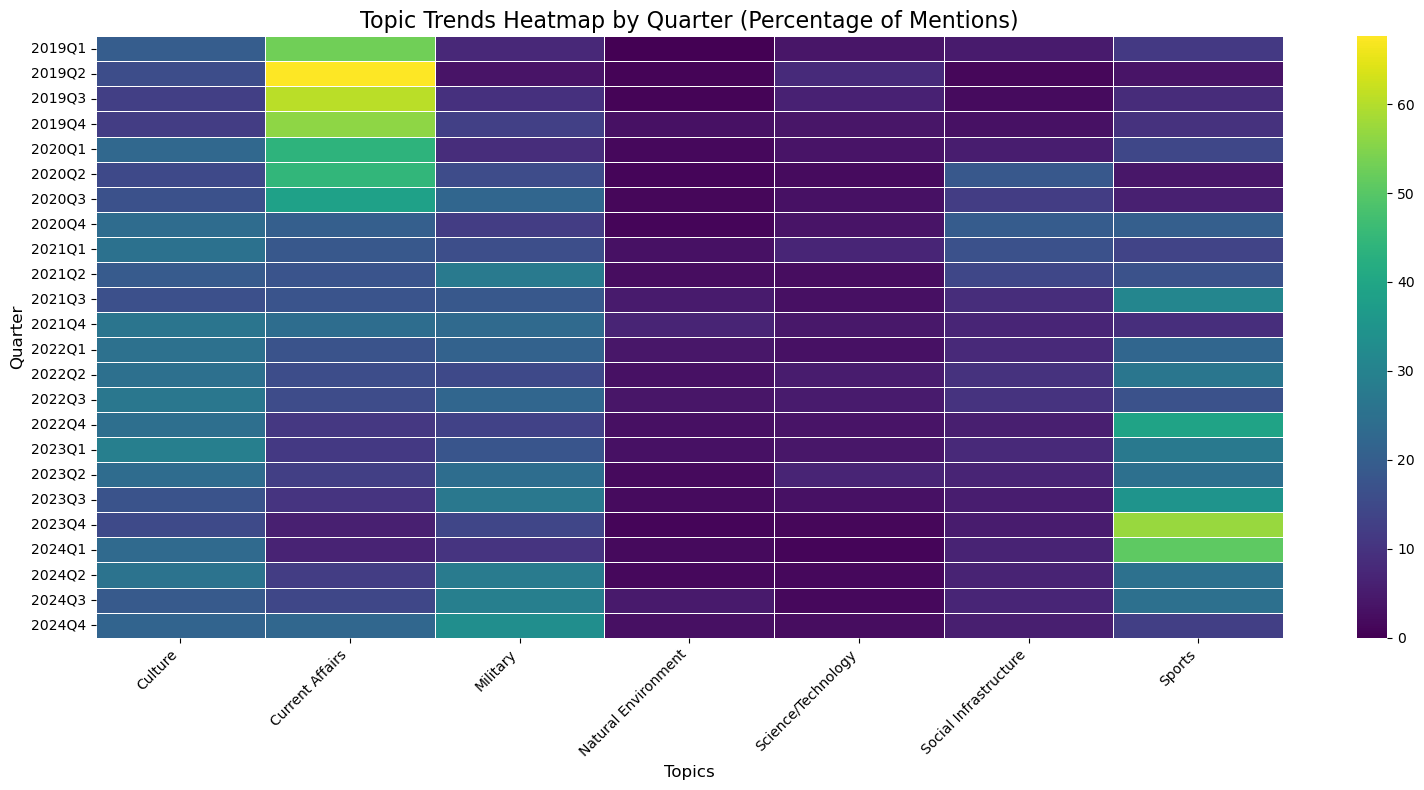

In [21]:
import seaborn as sns

plt.figure(figsize=(16, 8)) # Adjust size as needed
sns.heatmap(filtered_pivot_df, cmap='viridis', annot=False, fmt=".1f", linewidths=.5)
# annot=True adds the percentage numbers, but can clutter if many cells.
# fmt=".1f" formats the numbers to one decimal place if annot=True

plt.title('Topic Trends Heatmap by Quarter (Percentage of Mentions)', fontsize=16)
plt.xlabel('Topics', fontsize=12)
plt.ylabel('Quarter', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# First, identify rows with no country mentions before exploding
df['Country Mentions'] = df['Country Mentions'].apply(lambda x: x if isinstance(x, list) and x != [] else None)

# Create a new column for entries without country mentions
#df['No Country Mention'] = df['Country Mentions'].isna()

# Group by quarter and count the 'No Country Mention'
#no_country_mentions = df.groupby('Quarter')['No Country Mention'].sum().reset_index(name='Count')

expanded_countries_df = df.explode('Country Mentions')
country_counts_by_quarter = expanded_countries_df.groupby(['Quarter', 'Country Mentions']).size().reset_index(name='Count')
pivot_country_counts_df = country_counts_by_quarter.pivot(index='Quarter', columns='Country Mentions', values='Count').fillna(0)
pivot_country_counts_df = pivot_country_counts_df[pivot_country_counts_df.index >= '2019Q1']

# # Add the 'No Country Mention' counts to your existing DataFrame
# pivot_country_counts_df = pivot_country_counts_df.merge(no_country_mentions, on='Quarter', how='left')
# pivot_country_counts_df = pivot_country_counts_df.fillna(0)  # Fill NaNs with 0 for quarters where there are no such entries

In [16]:
# Check data types in the DataFrame
print(pivot_country_counts_df.dtypes)

# Convert all columns that should be numeric to numeric type, coerce errors to NaN
for column in pivot_country_counts_df.columns:
    pivot_country_counts_df[column] = pd.to_numeric(pivot_country_counts_df[column], errors='coerce')

# Now try to sum and sort again
try:
    total_country_mentions = pivot_country_counts_df.sum().sort_values(ascending=False)
    print("Sum and sorting successful.")
except TypeError as e:
    print("Error after conversion attempt:", e)

Country Mentions
Afghanistan          float64
Algeria              float64
Angola               float64
Argentina            float64
Australia            float64
Austria              float64
Azerbaijan           float64
Bahrain              float64
Bangladesh           float64
Belarus              float64
Belgium              float64
Benin                float64
Bolivia              float64
Botswana             float64
Brazil               float64
Bulgaria             float64
Cambodia             float64
Canada               float64
Chile                float64
China                float64
Colombia             float64
Croatia              float64
Cuba                 float64
Czechia              float64
DRC                  float64
Denmark              float64
Dominica Republic    float64
Ecuador              float64
Egypt                float64
Estonia              float64
Ethiopia             float64
Finland              float64
France               float64
Gabon                float

In [17]:
# Create a list of top 5 countries
# top_5_countries = total_country_mentions.head(5).index.tolist()

total_country_mentions = pivot_country_counts_df.sum().sort_values(ascending=False)
top_5_countries = total_country_mentions.head(3).index
filtered_country_counts_df = pivot_country_counts_df[top_5_countries]

# Filter out the top 5 countries from the DataFrame to calculate the sum of 'Others'
other_countries_df = pivot_country_counts_df.drop(top_5_countries, axis=1, errors='ignore')
pivot_country_counts_df['Others'] = other_countries_df.sum(axis=1)

# Add 'No Country Mention' if 'Country Mentions' can be empty or null
# if 'No Country Mention' not in pivot_country_counts_df.columns:
#     pivot_country_counts_df['No Country Mention'] = pivot_country_counts_df.apply(lambda row: 0 if row.sum() > 0 else 1, axis=1)

# Step 2: Filter DataFrame for plotting including 'Others' and 'No Country Mention'
filtered_country_counts_df = pivot_country_counts_df[list(top_5_countries) + ['Others']]
# filtered_country_counts_df = pivot_country_counts_df[top_5_countries + ['Others']]


/tmp/ipykernel_757446/1369543477.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_country_counts_df['Others'] = other_countries_df.sum(axis=1)


In [18]:
# Calculate total mentions including 'No Country Mention'
total_country_mentions = pivot_country_counts_df.sum().sort_values(ascending=False)

# Exclude 'No Country Mention' from the top 5 calculation
# top_5_countries = total_country_mentions.drop('No Country Mention', errors='ignore').head(5).index

# Prepare filtered DataFrame for the top 5 countries
filtered_country_counts_df = pivot_country_counts_df[top_5_countries]

# Filter out the top 5 countries from the DataFrame to calculate the sum of 'Others'
# Exclude 'No Country Mention' from the 'Others' calculation
other_countries_df = pivot_country_counts_df.drop(top_5_countries.tolist(), axis=1, errors='ignore')
pivot_country_counts_df['Others'] = other_countries_df.sum(axis=1)

# Update filtered DataFrame for plotting including 'Others' and 'No Country Mention'
filtered_country_counts_df = pivot_country_counts_df[list(top_5_countries) + ['Others']]

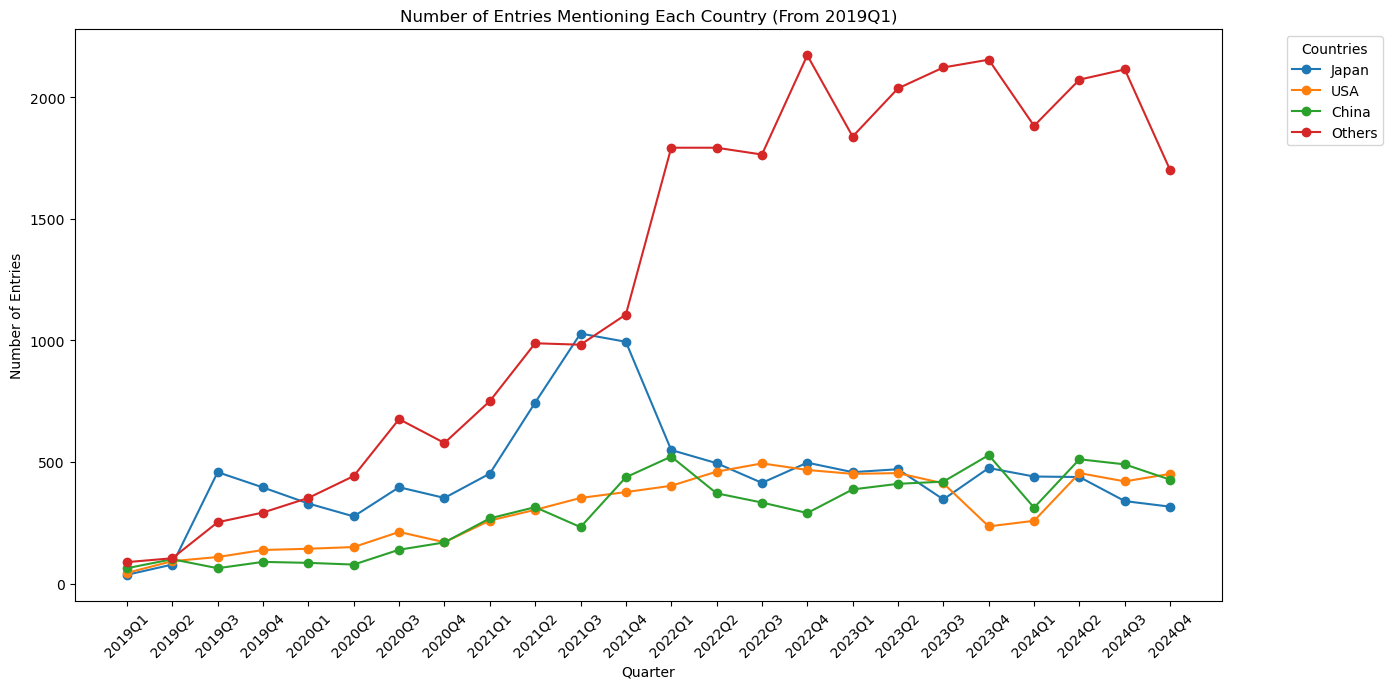

In [19]:
plt.figure(figsize=(14, 7))

for column in filtered_country_counts_df.columns:
    y_data = filtered_country_counts_df[column].values  # Converts to a NumPy array
    x_data = filtered_country_counts_df.index.values  # Converts index to a NumPy array
    plt.plot(x_data, y_data, marker='o', label=column)

plt.title('Number of Entries Mentioning Each Country (From 2019Q1)')
plt.xlabel('Quarter')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# # quarterly_entries_count = df.groupby('Quarter').size()
# # percentage_country_mentions_df = filtered_country_counts_df.divide(quarterly_entries_count, axis=0) * 100

# # Calculate the total number of country mentions per quarter
# quarterly_country_mention_count = pivot_country_counts_df.sum(axis=1)

# # Calculate percentage of country mentions
# percentage_country_mentions_df = filtered_country_counts_df.divide(quarterly_country_mention_count, axis=0) * 100


In [20]:
df['Country Mentions'] = df['Country Mentions'].apply(lambda x: x if isinstance(x, list) else [])

# 1. Prepare data for counting: Filter out empty lists and explode
df_countries_exploded = df[df['Country Mentions'].apply(lambda x: len(x) > 0)].explode('Country Mentions')

# 2. Count unique entries per country per quarter
country_entry_counts = df_countries_exploded.groupby(['Quarter', 'Country Mentions']).size().reset_index(name='EntryCount')
country_entry_counts = country_entry_counts.rename(columns={'Country Mentions': 'Country'})

# 3. Pivot to get quarterly counts of entries mentioning each country
pivot_country_counts_df = country_entry_counts.pivot_table(index='Quarter', columns='Country', values='EntryCount').fillna(0)

# 4. Identify top N countries (e.g., top 5 overall based on total mentions)
# Make sure to get the index directly
top_n = 3
top_n_countries = pivot_country_counts_df.sum().nlargest(top_n).index.tolist()

# 5. Calculate 'Others'
# Identify countries that are NOT in the top_n_countries
other_country_columns = [col for col in pivot_country_counts_df.columns if col not in top_n_countries]

# Calculate the sum of counts for 'Others'
if other_country_columns:
    pivot_country_counts_df['Others'] = pivot_country_counts_df[other_country_columns].sum(axis=1)
else:
    # If there are fewer than top_n unique countries, 'Others' should be 0
    pivot_country_counts_df['Others'] = 0

# 6. Create the final filtered DataFrame for plotting, including top N and 'Others'
columns_for_plotting = top_n_countries + ['Others']
# Ensure all columns exist before trying to select them
# If a top_n_country is not in pivot_country_counts_df, it will cause an error.
# This might happen if 'top_n_countries' is derived from a broader set than the actual data.
# A safer way to select:
final_plot_df_counts = pivot_country_counts_df[columns_for_plotting]


# 7. Get total number of entries per quarter for percentage calculation
quarterly_entries_count = df.groupby('Quarter').size() # Total entries in the original df

# 8. Calculate "Percentage of Entries Mentioning a Country" including 'Others'
percentage_country_mentions_df_entries = final_plot_df_counts.divide(quarterly_entries_count, axis=0) * 100
percentage_country_mentions_df_entries = percentage_country_mentions_df_entries[percentage_country_mentions_df_entries.index >= '2019Q1']
percentage_country_mentions_df_entries.fillna(0, inplace=True)


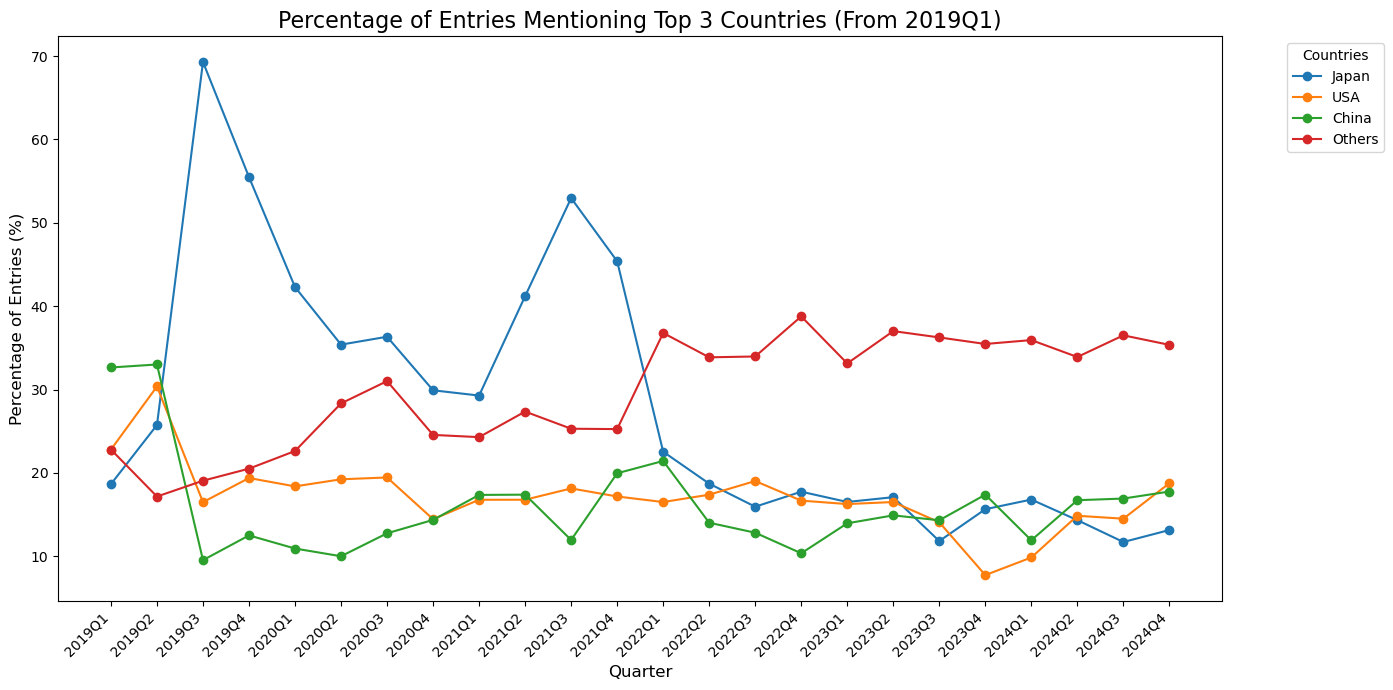

In [22]:
plt.figure(figsize=(14, 7))

for country in percentage_country_mentions_df_entries.columns:
    plt.plot(percentage_country_mentions_df_entries.index.values, # Convert index to numpy array
             percentage_country_mentions_df_entries[country].values, # Convert Series to numpy array
             marker='o', label=country)

plt.title('Percentage of Entries Mentioning Top 3 Countries (From 2019Q1)', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Percentage of Entries (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # ha='right' aligns the labels better
plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.grid(True, linestyle='--', alpha=0.7) # Added grid for readability

plt.tight_layout()
plt.show()

In [68]:
df['Mentions_Japan'] = df['Country Mentions'].apply(lambda x: 'Japan' in x if x is not None else False)

aggregated_data = df.groupby(['Quarter', 'Mentions_Japan'])[['View Count', 'Comment Count']].sum().reset_index()

In [71]:
average_data = df.groupby(['Quarter', 'Mentions_Japan'])[['View Count', 'Comment Count']].mean().reset_index()

pivot_avg_view_counts = average_data.pivot(index='Quarter', columns='Mentions_Japan', values='View Count')
pivot_avg_comment_counts = average_data.pivot(index='Quarter', columns='Mentions_Japan', values='Comment Count')

pivot_avg_view_counts = pivot_avg_view_counts[(pivot_avg_view_counts.index >= '2019Q1') & (pivot_avg_view_counts.index <= '2023Q4')]
pivot_avg_comment_counts = pivot_avg_comment_counts[(pivot_avg_comment_counts.index >= '2019Q1') & (pivot_avg_comment_counts.index <= '2023Q4')]

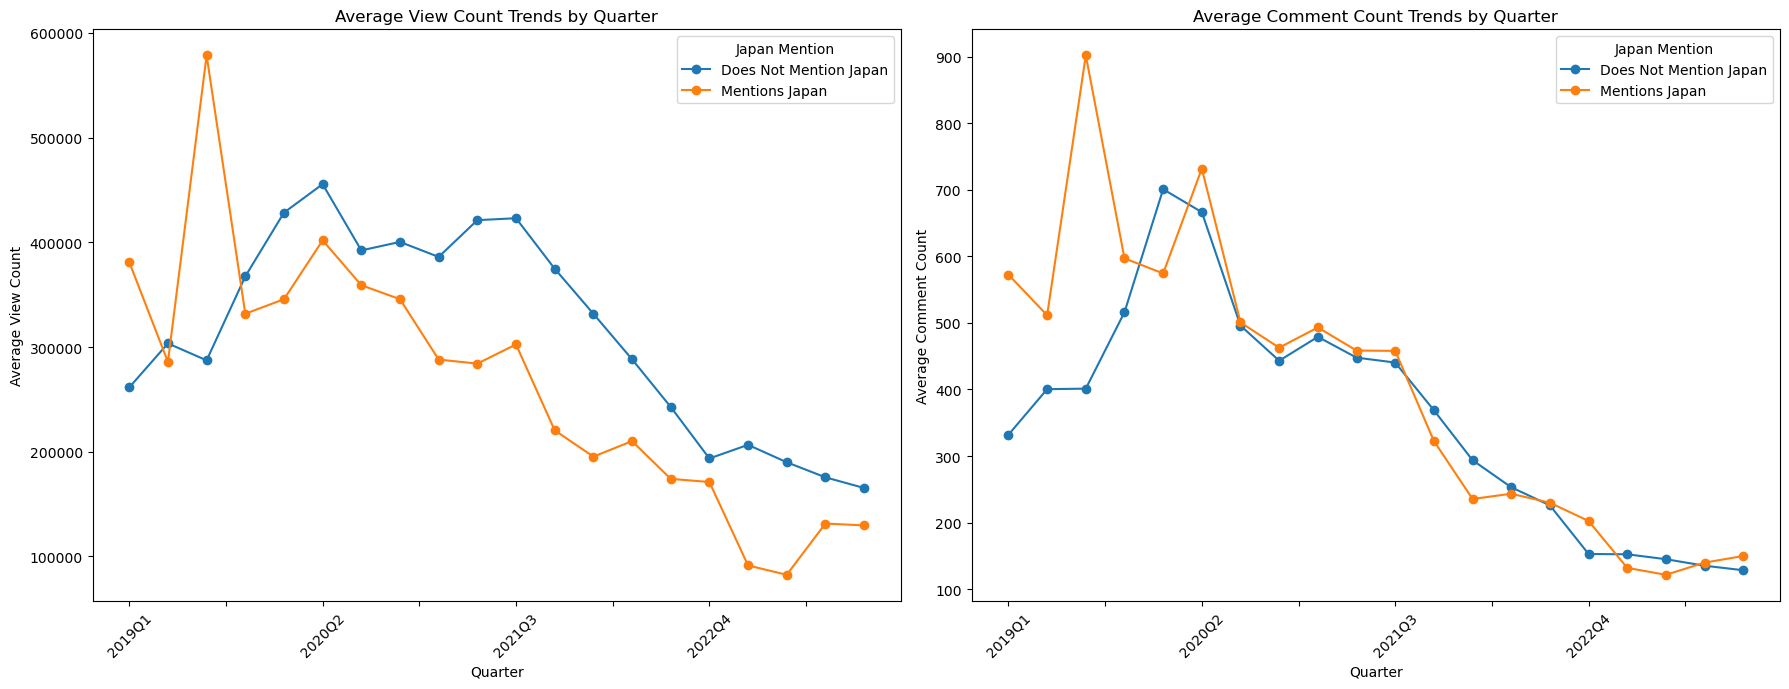

In [72]:
plt.figure(figsize=(18, 7))

# Average View Count Trends
plt.subplot(1, 2, 1)
pivot_avg_view_counts.plot(marker='o', ax=plt.gca())
plt.title('Average View Count Trends by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average View Count')
plt.xticks(rotation=45)
plt.legend(['Does Not Mention Japan', 'Mentions Japan'], title='Japan Mention')

# Average Comment Count Trends
plt.subplot(1, 2, 2)
pivot_avg_comment_counts.plot(marker='o', ax=plt.gca())
plt.title('Average Comment Count Trends by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Comment Count')
plt.xticks(rotation=45)
plt.legend(['Does Not Mention Japan', 'Mentions Japan'], title='Japan Mention')

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # For confidence intervals

In [14]:
# --- IMPORTANT: Ensure 'Publish Date' is datetime and 'Quarter' is Period ---
# If your 'Publish Date' is not yet datetime, convert it:
df['Publish Date'] = pd.to_datetime(df['Publish Date'])

# Convert 'Publish Date' to Quarter (e.g., '2019Q1') as a Period object
df['Quarter'] = df['Publish Date'].dt.to_period('Q')

# Sort by Quarter for proper plotting order
df = df.sort_values(by='Quarter')

# --- 1. Handle None values and create 'Mentions_Japan' ---
df['Mentions_Japan'] = df['Country Mentions'].apply(lambda x: 'Japan' in x if x is not None else False)

# --- 2. Calculate Mean, Standard Error of Mean (SEM), and Count ---
grouped_stats = df.groupby(['Quarter', 'Mentions_Japan']).agg(
    Avg_View_Count=('View Count', 'mean'),
    SEM_View_Count=('View Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
    Count_View_Count=('View Count', 'count'),
    Avg_Comment_Count=('Comment Count', 'mean'),
    SEM_Comment_Count=('Comment Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
    Count_Comment_Count=('Comment Count', 'count')
).reset_index()

# --- 3. Calculate 95% Confidence Intervals ---
alpha = 0.05

def calculate_ci_bounds(row, avg_col, sem_col, count_col):
    mean = row[avg_col]
    sem = row[sem_col]
    count = row[count_col]

    if pd.isna(sem) or count < 2:
        return np.nan, np.nan
    
    margin_of_error = stats.t.ppf(1 - alpha/2, df=count-1) * sem
    
    return mean - margin_of_error, mean + margin_of_error

grouped_stats[['CI_View_Lower', 'CI_View_Upper']] = grouped_stats.apply(
    lambda row: calculate_ci_bounds(row, 'Avg_View_Count', 'SEM_View_Count', 'Count_View_Count'),
    axis=1, result_type='expand'
)
grouped_stats[['CI_Comment_Lower', 'CI_Comment_Upper']] = grouped_stats.apply(
    lambda row: calculate_ci_bounds(row, 'Avg_Comment_Count', 'SEM_Comment_Count', 'Count_Comment_Count'),
    axis=1, result_type='expand'
)

/tmp/ipykernel_3976082/2354443619.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Quarter'] = df['Publish Date'].dt.to_period('Q')


In [27]:
# --- 4. Pivot the data for plotting ---
# Convert Quarter to string to avoid issues with Period objects
grouped_stats['Quarter_str'] = grouped_stats['Quarter'].astype(str)

# Pivot using the string representation of Quarter
pivot_avg_view_counts = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='Avg_View_Count')
pivot_ci_view_lower = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='CI_View_Lower')
pivot_ci_view_upper = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='CI_View_Upper')

pivot_avg_comment_counts = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='Avg_Comment_Count')
pivot_ci_comment_lower = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='CI_Comment_Lower')
pivot_ci_comment_upper = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='CI_Comment_Upper')

pivot_counts = grouped_stats.pivot(index='Quarter_str', columns='Mentions_Japan', values='Count_View_Count')

# --- 5. Filter to the desired date range ---
# First, create a mapping of quarter strings to their Period objects for filtering
grouped_stats_with_quarter_period = grouped_stats.copy()
grouped_stats_with_quarter_period['Quarter_period'] = grouped_stats_with_quarter_period['Quarter']

# Create a mapping dictionary
quarter_mapping = dict(zip(grouped_stats_with_quarter_period['Quarter_str'], 
                          grouped_stats_with_quarter_period['Quarter_period']))

# Filter the quarters we want
start_q = pd.Period('2019Q1', freq='Q')
end_q = pd.Period('2024Q4', freq='Q')

# Get list of quarters (as strings) within our range
quarters_in_range = []
for q_str, q_period in quarter_mapping.items():
    if q_period >= start_q and q_period <= end_q:
        quarters_in_range.append(q_str)

# Filter all pivoted DataFrames to include only quarters in our range
pivot_avg_view_counts = pivot_avg_view_counts[pivot_avg_view_counts.index.isin(quarters_in_range)]
pivot_ci_view_lower = pivot_ci_view_lower[pivot_ci_view_lower.index.isin(quarters_in_range)]
pivot_ci_view_upper = pivot_ci_view_upper[pivot_ci_view_upper.index.isin(quarters_in_range)]

pivot_avg_comment_counts = pivot_avg_comment_counts[pivot_avg_comment_counts.index.isin(quarters_in_range)]
pivot_ci_comment_lower = pivot_ci_comment_lower[pivot_ci_comment_lower.index.isin(quarters_in_range)]
pivot_ci_comment_upper = pivot_ci_comment_upper[pivot_ci_comment_upper.index.isin(quarters_in_range)]

pivot_counts = pivot_counts[pivot_counts.index.isin(quarters_in_range)]

# Sort the filtered DataFrames by their quarter string index
def sort_quarters(quarters):
    # Convert quarters to a proper format for sorting
    return sorted(quarters, key=lambda q: pd.Period(q))

sorted_quarters = sort_quarters(pivot_avg_view_counts.index)

pivot_avg_view_counts = pivot_avg_view_counts.reindex(sorted_quarters)
pivot_ci_view_lower = pivot_ci_view_lower.reindex(sorted_quarters)
pivot_ci_view_upper = pivot_ci_view_upper.reindex(sorted_quarters)

pivot_avg_comment_counts = pivot_avg_comment_counts.reindex(sorted_quarters)
pivot_ci_comment_lower = pivot_ci_comment_lower.reindex(sorted_quarters)
pivot_ci_comment_upper = pivot_ci_comment_upper.reindex(sorted_quarters)

pivot_counts = pivot_counts.reindex(sorted_quarters)

color_false = 'tab:blue'      # For 'Does Not Mention Japan' (False)
color_true = 'tab:red'     # For 'Mentions Japan' (True)

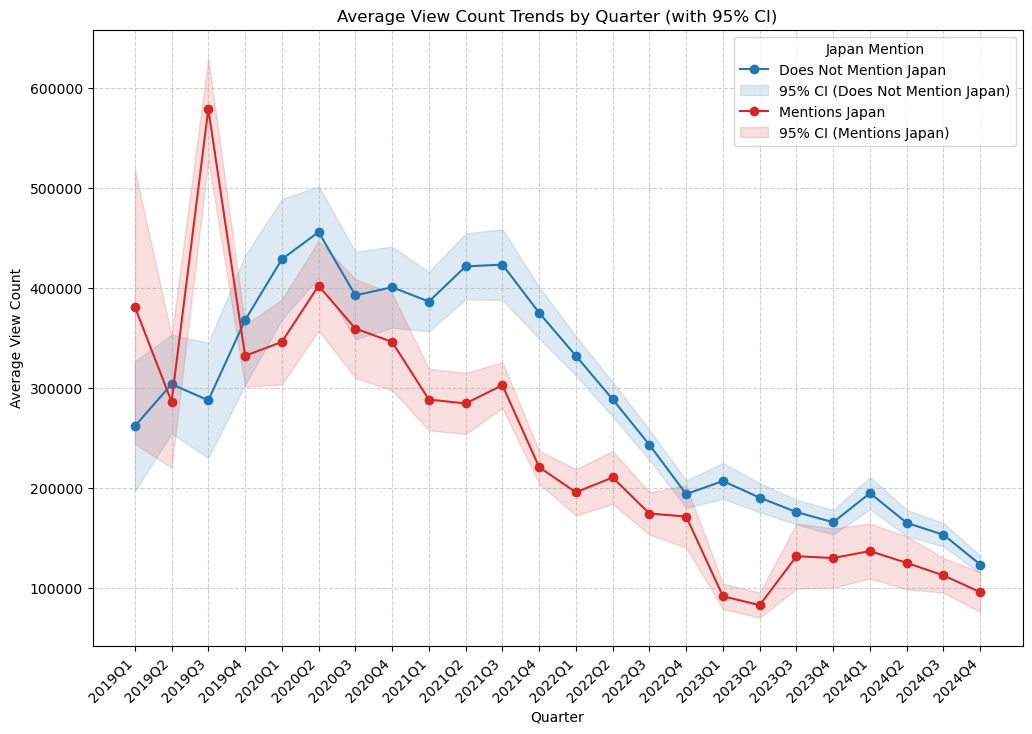

In [28]:
# --- 6. Plotting with Confidence Intervals and Sample Sizes ---
plt.figure(figsize=(12, 8))

# --- Plot 1: Average View Count Trends with CI ---
#plt.subplot(1, 3, 1)

# Convert to numpy arrays before plotting to avoid pandas issues
x_values = pivot_avg_view_counts.index.to_numpy()

# Safely handle missing values for False
if False in pivot_avg_view_counts.columns:
    y_false = pivot_avg_view_counts[False].fillna(np.nan).to_numpy()
    lower_false = pivot_ci_view_lower[False].fillna(np.nan).to_numpy()
    upper_false = pivot_ci_view_upper[False].fillna(np.nan).to_numpy()
    plt.plot(x_values, y_false, marker='o', label='Does Not Mention Japan', color=color_false)
    plt.fill_between(x_values, lower_false, upper_false, color=color_false, alpha=0.15, label='95% CI (Does Not Mention Japan)')

# Safely handle missing values for True
if True in pivot_avg_view_counts.columns:
    y_true = pivot_avg_view_counts[True].fillna(np.nan).to_numpy()
    lower_true = pivot_ci_view_lower[True].fillna(np.nan).to_numpy()
    upper_true = pivot_ci_view_upper[True].fillna(np.nan).to_numpy()
    plt.plot(x_values, y_true, marker='o', label='Mentions Japan', color=color_true)
    plt.fill_between(x_values, lower_true, upper_true, color=color_true, alpha=0.15, label='95% CI (Mentions Japan)')

plt.title('Average View Count Trends by Quarter (with 95% CI)')
plt.xlabel('Quarter')
plt.ylabel('Average View Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Japan Mention', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)

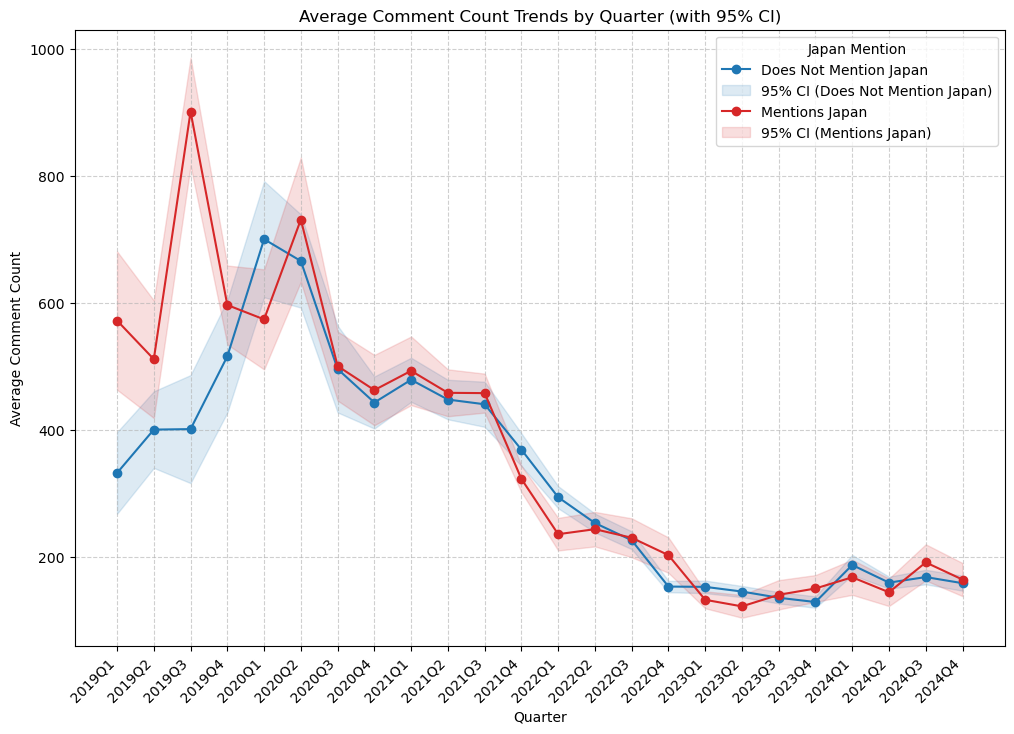

In [24]:
# --- Plot 2: Average Comment Count Trends with CI ---
plt.figure(figsize=(12, 8))

# Safely handle missing values for False
if False in pivot_avg_comment_counts.columns:
    y_false = pivot_avg_comment_counts[False].fillna(np.nan).to_numpy()
    lower_false = pivot_ci_comment_lower[False].fillna(np.nan).to_numpy()
    upper_false = pivot_ci_comment_upper[False].fillna(np.nan).to_numpy()
    plt.plot(x_values, y_false, marker='o', label='Does Not Mention Japan', color=color_false)
    plt.fill_between(x_values, lower_false, upper_false, color=color_false, alpha=0.15, label='95% CI (Does Not Mention Japan)')

# Safely handle missing values for True
if True in pivot_avg_comment_counts.columns:
    y_true = pivot_avg_comment_counts[True].fillna(np.nan).to_numpy()
    lower_true = pivot_ci_comment_lower[True].fillna(np.nan).to_numpy()
    upper_true = pivot_ci_comment_upper[True].fillna(np.nan).to_numpy()
    plt.plot(x_values, y_true, marker='o', label='Mentions Japan', color=color_true)
    plt.fill_between(x_values, lower_true, upper_true, color=color_true, alpha=0.15, label='95% CI (Mentions Japan)')

plt.title('Average Comment Count Trends by Quarter (with 95% CI)')
plt.xlabel('Quarter')
plt.ylabel('Average Comment Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Japan Mention', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)

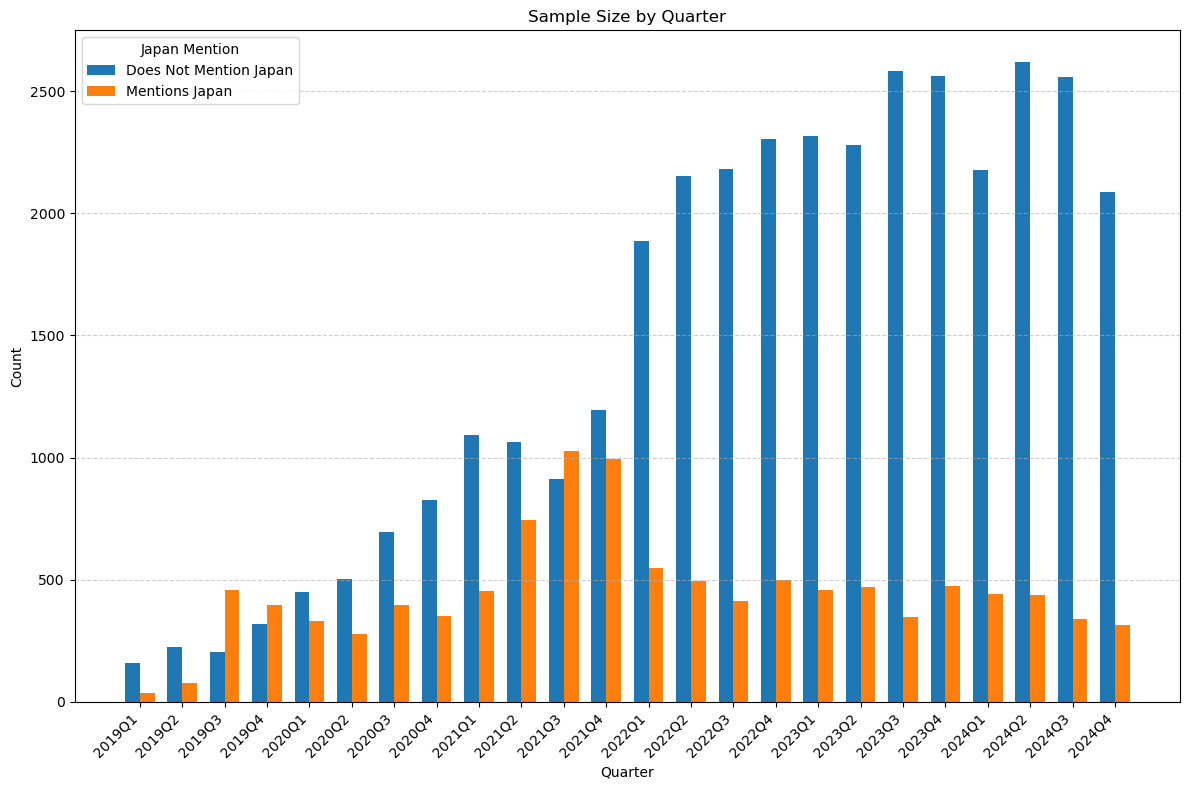

In [123]:
# --- Plot 3: Sample Size Counts ---
plt.figure(figsize=(12, 8))

# Set bar width
bar_width = 0.35
x = np.arange(len(x_values))

# Safely handle missing values for False and True
false_counts = np.zeros(len(x_values))
true_counts = np.zeros(len(x_values))

if False in pivot_counts.columns:
    false_counts = pivot_counts[False].fillna(0).to_numpy()
    
if True in pivot_counts.columns:
    true_counts = pivot_counts[True].fillna(0).to_numpy()

plt.bar(x - bar_width/2, false_counts, bar_width, label='Does Not Mention Japan', color=color_false)
plt.bar(x + bar_width/2, true_counts, bar_width, label='Mentions Japan', color=color_true)

plt.title('Sample Size by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(x, x_values, rotation=45, ha='right')
plt.legend(title='Japan Mention', loc='best')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

plt.tight_layout()
plt.show()

In [124]:
# --- Initial Preprocessing: Handle None values and create 'Mentions_Country' columns ---
df['Country Mentions'] = df['Country Mentions'].fillna('') # Fill None for safe string operations

df['Mentions_Japan'] = df['Country Mentions'].apply(lambda x: 'Japan' in x)
df['Mentions_China'] = df['Country Mentions'].apply(lambda x: 'China' in x)
df['Mentions_US'] = df['Country Mentions'].apply(lambda x: 'USA' in x)

# --- Define the aggregation function (re-using part of the previous logic) ---
def aggregate_country_stats(df_input, mention_col_name, country_name_abbr):
    """
    Aggregates mean, SEM, count, and CI for a specific country mention.
    Returns a DataFrame with quarter as index and country-specific columns.
    """
    df_country = df_input[df_input[mention_col_name]].copy()

    if df_country.empty:
        # Return an empty DataFrame that can be merged, ensuring Quarter column is there
        # Define dummy column names that will be expected in the merge
        cols = ['Quarter',
                f'{country_name_abbr}_Avg_View_Count', f'{country_name_abbr}_SEM_View_Count',
                f'{country_name_abbr}_Count_View_Count', f'{country_name_abbr}_CI_View_Lower',
                f'{country_name_abbr}_CI_View_Upper',
                f'{country_name_abbr}_Avg_Comment_Count', f'{country_name_abbr}_SEM_Comment_Count',
                f'{country_name_abbr}_Count_Comment_Count', f'{country_name_abbr}_CI_Comment_Lower',
                f'{country_name_abbr}_CI_Comment_Upper']
        return pd.DataFrame(columns=cols).set_index('Quarter') # Set index to Quarter for merge

    grouped_stats = df_country.groupby('Quarter').agg(
        Avg_View_Count=('View Count', 'mean'),
        SEM_View_Count=('View Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
        Count_View_Count=('View Count', 'count'),
        Avg_Comment_Count=('Comment Count', 'mean'),
        SEM_Comment_Count=('Comment Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
        Count_Comment_Count=('Comment Count', 'count')
    ) # No reset_index() here, Quarter will be the index

    alpha = 0.05
    def calculate_ci_bounds(row, avg_col, sem_col, count_col):
        mean = row[avg_col]
        sem = row[sem_col]
        count = row[count_col]
        if pd.isna(sem) or count < 2:
            return np.nan, np.nan
        margin_of_error = stats.t.ppf(1 - alpha/2, df=count-1) * sem
        return mean - margin_of_error, mean + margin_of_error

    grouped_stats[['CI_View_Lower', 'CI_View_Upper']] = grouped_stats.apply(
        lambda row: calculate_ci_bounds(row, 'Avg_View_Count', 'SEM_View_Count', 'Count_View_Count'),
        axis=1, result_type='expand'
    )
    grouped_stats[['CI_Comment_Lower', 'CI_Comment_Upper']] = grouped_stats.apply(
        lambda row: calculate_ci_bounds(row, 'Avg_Comment_Count', 'SEM_Comment_Count', 'Count_Comment_Count'),
        axis=1, result_type='expand'
    )

    # Rename columns with country prefix
    col_map = {
        'Avg_View_Count': f'{country_name_abbr}_Avg_View_Count',
        'SEM_View_Count': f'{country_name_abbr}_SEM_View_Count',
        'Count_View_Count': f'{country_name_abbr}_Count_View_Count',
        'CI_View_Lower': f'{country_name_abbr}_CI_View_Lower',
        'CI_View_Upper': f'{country_name_abbr}_CI_View_Upper',
        'Avg_Comment_Count': f'{country_name_abbr}_Avg_Comment_Count',
        'SEM_Comment_Count': f'{country_name_abbr}_SEM_Comment_Count',
        'Count_Comment_Count': f'{country_name_abbr}_Count_Comment_Count',
        'CI_Comment_Lower': f'{country_name_abbr}_CI_Comment_Lower',
        'CI_Comment_Upper': f'{country_name_abbr}_CI_Comment_Upper',
    }
    return grouped_stats.rename(columns=col_map)


# --- Filter the DataFrame for quarters after 2019Q1 (using Period objects) ---
start_quarter_filter = pd.Period('2019Q1', freq='Q')
df_filtered_quarters = df[df['Quarter'] >= start_quarter_filter].copy()

# --- Aggregate data for each country and merge ---
all_country_data = []

# Using a list of tuples for easy iteration: (mention_column_name, country_label)
countries_to_analyze = [
    ('Mentions_Japan', 'Japan'),
    ('Mentions_China', 'China'),
    ('Mentions_US', 'US')
]

for mention_col, country_label in countries_to_analyze:
    country_df = aggregate_country_stats(df_filtered_quarters, mention_col, country_label)
    all_country_data.append(country_df)

# Merge all aggregated dataframes on Quarter (index)
# Use outer join to keep all quarters from all countries
# Ensure the first DataFrame is used as the base
full_aggregated_data = all_country_data[0]
for i in range(1, len(all_country_data)):
    full_aggregated_data = full_aggregated_data.merge(all_country_data[i], on='Quarter', how='outer')

# Sort by Quarter index to ensure correct plotting order
full_aggregated_data = full_aggregated_data.sort_index()

# Convert Quarter index to string for plotting
full_aggregated_data['Quarter_str'] = full_aggregated_data.index.astype(str)

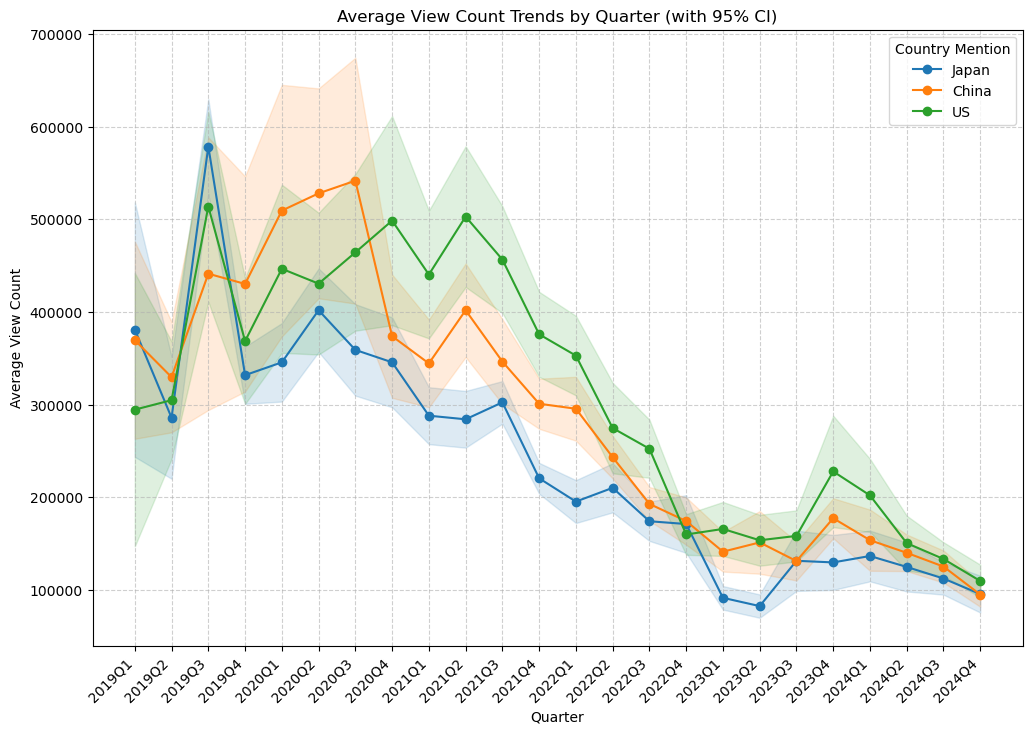

In [ ]:
# --- Plotting ---
plt.figure(figsize=(12, 8))

# Define a consistent color map for countries
country_colors = {
    'Japan': 'tab:blue',
    'China': 'tab:orange',
    'US': 'tab:green'
}

# --- Plot 1: Average View Count Trends with 95% CI ---

for mention_col, country_label in countries_to_analyze:
    avg_col = f'{country_label}_Avg_View_Count'
    lower_ci_col = f'{country_label}_CI_View_Lower'
    upper_ci_col = f'{country_label}_CI_View_Upper'

    # Check if the average column exists in the DataFrame for robustness
    if avg_col in full_aggregated_data.columns:
        # Get x-axis values (quarter strings)
        x_values = full_aggregated_data['Quarter_str'].to_numpy()
        # Get y-values and CI bounds, handling NaNs and converting to NumPy arrays
        y_values = full_aggregated_data[avg_col].fillna(np.nan).to_numpy()
        lower_values = full_aggregated_data[lower_ci_col].fillna(np.nan).to_numpy()
        upper_values = full_aggregated_data[upper_ci_col].fillna(np.nan).to_numpy()

        # Plot the mean line
        plt.plot(x_values, y_values, marker='o', label=country_label, color=country_colors[country_label])
        # Plot the confidence interval as a shaded area
        plt.fill_between(x_values, lower_values, upper_values, color=country_colors[country_label], alpha=0.15)

plt.title('Average View Count Trends by Quarter (with 95% CI)')
plt.xlabel('Quarter')
plt.ylabel('Average View Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country Mention')
plt.grid(True, linestyle='--', alpha=0.6)

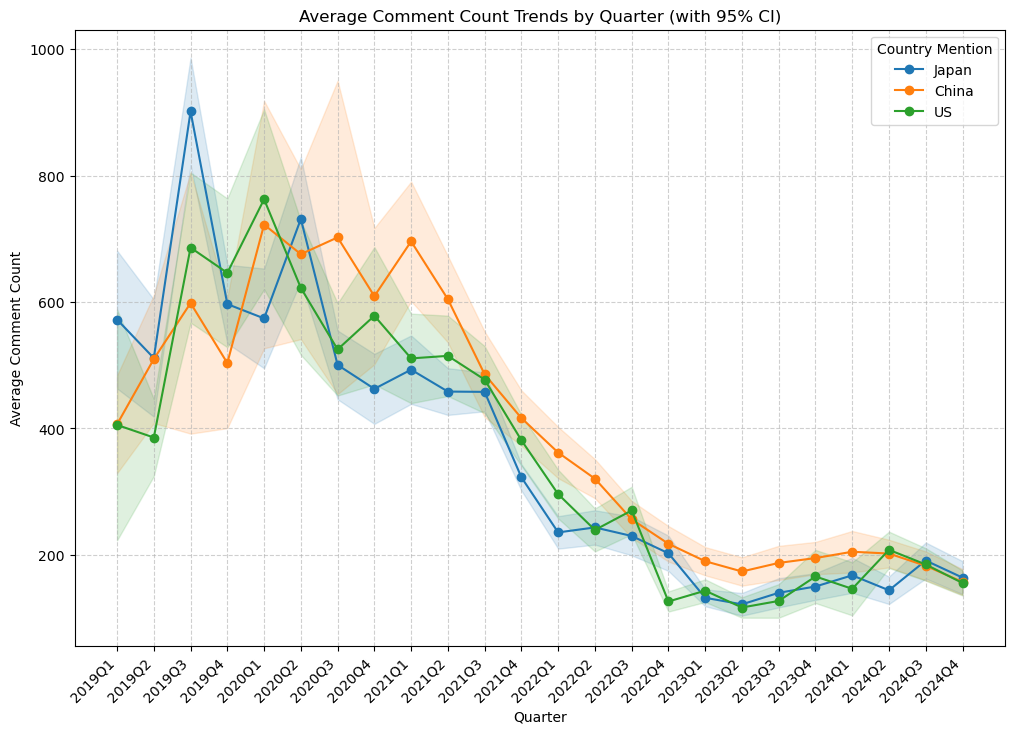

In [128]:
# --- Plot 2: Average Comment Count Trends with 95% CI ---
plt.figure(figsize=(12, 8))

for mention_col, country_label in countries_to_analyze:
    avg_col = f'{country_label}_Avg_Comment_Count'
    lower_ci_col = f'{country_label}_CI_Comment_Lower'
    upper_ci_col = f'{country_label}_CI_Comment_Upper'

    if avg_col in full_aggregated_data.columns:
        x_values = full_aggregated_data['Quarter_str'].to_numpy()
        y_values = full_aggregated_data[avg_col].fillna(np.nan).to_numpy()
        lower_values = full_aggregated_data[lower_ci_col].fillna(np.nan).to_numpy()
        upper_values = full_aggregated_data[upper_ci_col].fillna(np.nan).to_numpy()

        plt.plot(x_values, y_values, marker='o', label=country_label, color=country_colors[country_label])
        plt.fill_between(x_values, lower_values, upper_values, color=country_colors[country_label], alpha=0.15)

plt.title('Average Comment Count Trends by Quarter (with 95% CI)')
plt.xlabel('Quarter')
plt.ylabel('Average Comment Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country Mention')
plt.grid(True, linestyle='--', alpha=0.6)

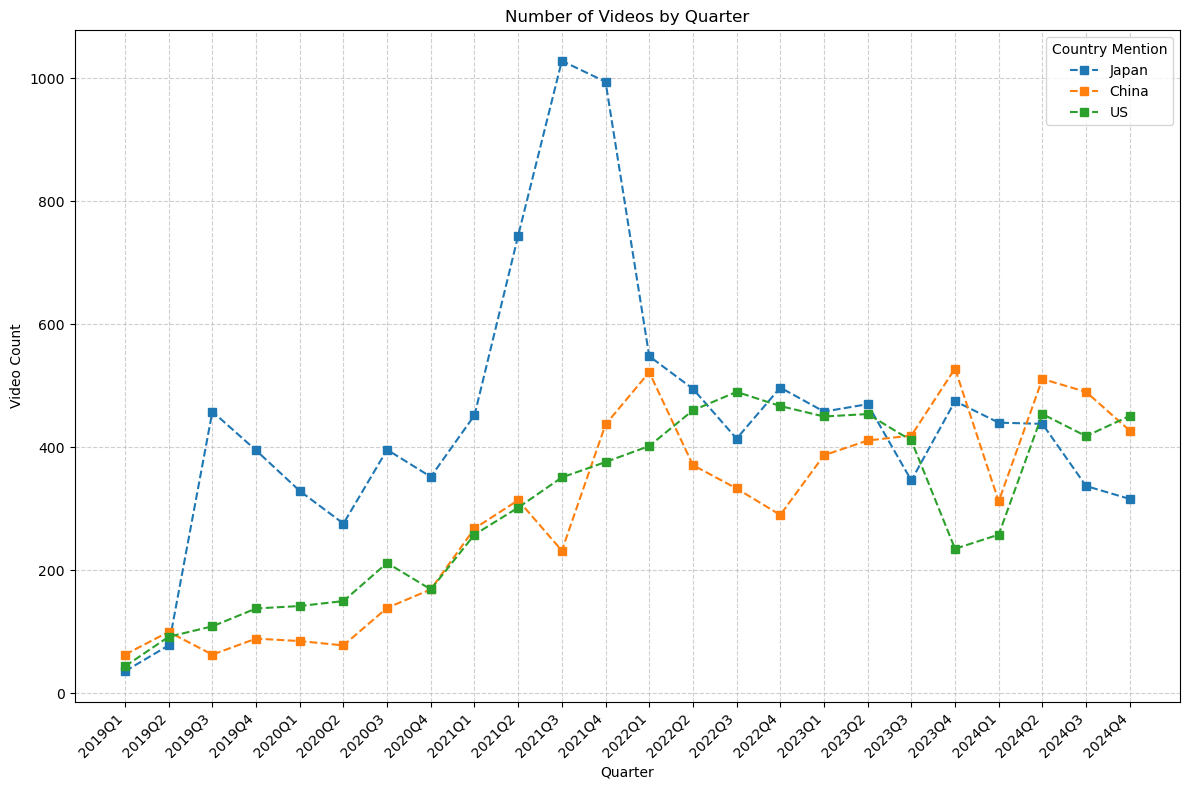

In [129]:
# --- Plot 3: Number of Videos by Quarter (Sample Size) ---
plt.figure(figsize=(12, 8))

for mention_col, country_label in countries_to_analyze:
    count_col = f'{country_label}_Count_View_Count' # Using View Count for count
    
    if count_col in full_aggregated_data.columns:
        x_values = full_aggregated_data['Quarter_str'].to_numpy()
        # Fill counts with 0 if no videos were present for that quarter/country, for clear plotting
        y_values = full_aggregated_data[count_col].fillna(0).to_numpy() 

        plt.plot(x_values, y_values, marker='s', linestyle='--', label=country_label, color=country_colors[country_label])

plt.title('Number of Videos by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Video Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country Mention')
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

In [136]:
def calculate_bootstrap_ci_median(data_series, n_bootstraps=1000, ci_level=0.95, random_state=42):
    """
    Calculates the median and its bootstrapped confidence interval.
    Returns (median, lower_ci, upper_ci) or (np.nan, np.nan, np.nan) if not enough data.
    """
    # Check if series is empty or all NaN
    if data_series.empty or data_series.isna().all():
        return np.nan, np.nan, np.nan
    
    valid_data = data_series.dropna().values
    
    # Require at least 5 data points for meaningful bootstrapping (can adjust)
    if len(valid_data) < 5: 
        return np.nan, np.nan, np.nan
    
    bootstrapped_medians = []
    rng = np.random.default_rng(random_state)  # For reproducible results
    
    for _ in range(n_bootstraps):  # Fixed typo: '*' -> '_'
        # Sample with replacement
        sample = rng.choice(valid_data, size=len(valid_data), replace=True)
        bootstrapped_medians.append(np.median(sample))
    
    lower_p = (1 - ci_level) / 2
    upper_p = 1 - lower_p
    
    current_median = np.median(valid_data)
    lower_ci = np.percentile(bootstrapped_medians, lower_p * 100)
    upper_ci = np.percentile(bootstrapped_medians, upper_p * 100)
    
    return current_median, lower_ci, upper_ci

def calculate_mean_ci(mean, sem, count, ci_level=0.95):
    """
    Calculates the mean confidence interval using t-distribution.
    Returns (lower_ci, upper_ci) or (np.nan, np.nan) if not enough data.
    """
    if count < 2 or pd.isna(sem):  # Need at least 2 data points for SEM to be non-NaN
        return np.nan, np.nan
    
    alpha = 1 - ci_level
    margin_of_error = stats.t.ppf(1 - alpha/2, df=count-1) * sem
    return mean - margin_of_error, mean + margin_of_error

# --- Define the aggregation function ---
def aggregate_country_stats(df_input, mention_col_name, country_name_abbr):
    """
    Aggregates mean, median, their CIs, and count for a specific country mention per quarter.
    """
    # First check if the column exists
    if mention_col_name not in df_input.columns:
        print(f"Warning: Column '{mention_col_name}' not found in DataFrame")
        # Return an empty DataFrame with expected columns and PeriodIndex
        quarters = df_input['Quarter'].unique()
        index = pd.PeriodIndex(quarters, freq='Q')
        cols = [
            f'{country_name_abbr}_Avg_View_Count', f'{country_name_abbr}_CI_View_Lower', f'{country_name_abbr}_CI_View_Upper',
            f'{country_name_abbr}_Med_View_Count', f'{country_name_abbr}_CI_Med_View_Lower', f'{country_name_abbr}_CI_Med_View_Upper',
            f'{country_name_abbr}_Count_View_Count',
            f'{country_name_abbr}_Avg_Comment_Count', f'{country_name_abbr}_CI_Comment_Lower', f'{country_name_abbr}_CI_Comment_Upper',
            f'{country_name_abbr}_Med_Comment_Count', f'{country_name_abbr}_CI_Med_Comment_Lower', f'{country_name_abbr}_CI_Med_Comment_Upper',
            f'{country_name_abbr}_Count_Comment_Count'
        ]
        return pd.DataFrame(columns=cols, index=index)
    
    # Filter the DataFrame based on the mention column
    df_country = df_input[df_input[mention_col_name]].copy()
    
    if df_country.empty:
        print(f"Warning: No rows found where '{mention_col_name}' is True")
        # Return an empty DataFrame with expected columns and PeriodIndex
        quarters = df_input['Quarter'].unique()
        index = pd.PeriodIndex(quarters, freq='Q')
        cols = [
            f'{country_name_abbr}_Avg_View_Count', f'{country_name_abbr}_CI_View_Lower', f'{country_name_abbr}_CI_View_Upper',
            f'{country_name_abbr}_Med_View_Count', f'{country_name_abbr}_CI_Med_View_Lower', f'{country_name_abbr}_CI_Med_View_Upper',
            f'{country_name_abbr}_Count_View_Count',
            f'{country_name_abbr}_Avg_Comment_Count', f'{country_name_abbr}_CI_Comment_Lower', f'{country_name_abbr}_CI_Comment_Upper',
            f'{country_name_abbr}_Med_Comment_Count', f'{country_name_abbr}_CI_Med_Comment_Lower', f'{country_name_abbr}_CI_Med_Comment_Upper',
            f'{country_name_abbr}_Count_Comment_Count'
        ]
        return pd.DataFrame(columns=cols, index=index)
    
    # Debug print
    print(f"Processing {country_name_abbr} data: {len(df_country)} rows")
    
    # Step 1: Perform standard aggregations (mean, SEM, count)
    grouped_stats = df_country.groupby('Quarter').agg(
        Avg_View_Count=('View Count', 'mean'),
        SEM_View_Count=('View Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
        Count_View_Count=('View Count', 'count'),  # Count of non-NaN View Counts
        Avg_Comment_Count=('Comment Count', 'mean'),
        SEM_Comment_Count=('Comment Count', lambda x: x.sem(ddof=1) if len(x) > 1 else np.nan),
        Count_Comment_Count=('Comment Count', 'count')  # Count of non-NaN Comment Counts
    )
    
    # Debug print
    print(f"{country_name_abbr} grouped stats has {len(grouped_stats)} quarters")
    
    # Step 2: Calculate Mean CIs
    grouped_stats[['CI_View_Lower', 'CI_View_Upper']] = grouped_stats.apply(
        lambda row: calculate_mean_ci(row['Avg_View_Count'], row['SEM_View_Count'], row['Count_View_Count']),
        axis=1, result_type='expand'
    )
    
    grouped_stats[['CI_Comment_Lower', 'CI_Comment_Upper']] = grouped_stats.apply(
        lambda row: calculate_mean_ci(row['Avg_Comment_Count'], row['SEM_Comment_Count'], row['Count_Comment_Count']),
        axis=1, result_type='expand'
    )
    
    # Step 3: Calculate Median & Median CIs using bootstrapping
    try:
        # For View Count
        median_view_results = df_country.groupby('Quarter')['View Count'].apply(calculate_bootstrap_ci_median).apply(pd.Series)
        median_view_results.columns = ['Med_View_Count', 'CI_Med_View_Lower', 'CI_Med_View_Upper']
        
        # For Comment Count
        median_comment_results = df_country.groupby('Quarter')['Comment Count'].apply(calculate_bootstrap_ci_median).apply(pd.Series)
        median_comment_results.columns = ['Med_Comment_Count', 'CI_Med_Comment_Lower', 'CI_Med_Comment_Upper']
        
        # Merge the median results back into grouped_stats
        final_grouped_stats = grouped_stats.merge(median_view_results, left_index=True, right_index=True, how='left')
        final_grouped_stats = final_grouped_stats.merge(median_comment_results, left_index=True, right_index=True, how='left')
    
    except Exception as e:
        print(f"Error in median calculation for {country_name_abbr}: {str(e)}")
        # If error, just use the grouped_stats without median info
        final_grouped_stats = grouped_stats.copy()
        # Add empty median columns
        for col in ['Med_View_Count', 'CI_Med_View_Lower', 'CI_Med_View_Upper', 
                   'Med_Comment_Count', 'CI_Med_Comment_Lower', 'CI_Med_Comment_Upper']:
            final_grouped_stats[col] = np.nan
    
    # Clean up intermediate SEM columns (already used for CI calculation)
    final_grouped_stats = final_grouped_stats.drop(columns=['SEM_View_Count', 'SEM_Comment_Count'])
    
    # Rename all columns with country prefix
    col_map = {
        'Avg_View_Count': f'{country_name_abbr}_Avg_View_Count',
        'Count_View_Count': f'{country_name_abbr}_Count_View_Count',
        'CI_View_Lower': f'{country_name_abbr}_CI_View_Lower',
        'CI_View_Upper': f'{country_name_abbr}_CI_View_Upper',
        'Med_View_Count': f'{country_name_abbr}_Med_View_Count',
        'CI_Med_View_Lower': f'{country_name_abbr}_CI_Med_View_Lower',
        'CI_Med_View_Upper': f'{country_name_abbr}_CI_Med_View_Upper',
        'Avg_Comment_Count': f'{country_name_abbr}_Avg_Comment_Count',
        'Count_Comment_Count': f'{country_name_abbr}_Count_Comment_Count',
        'CI_Comment_Lower': f'{country_name_abbr}_CI_Comment_Lower',
        'CI_Comment_Upper': f'{country_name_abbr}_CI_Comment_Upper',
        'Med_Comment_Count': f'{country_name_abbr}_Med_Comment_Count',
        'CI_Med_Comment_Lower': f'{country_name_abbr}_CI_Med_Comment_Lower',
        'CI_Med_Comment_Upper': f'{country_name_abbr}_CI_Med_Comment_Upper',
    }
    
    final_renamed = final_grouped_stats.rename(columns=col_map)
    
    # Debug: print a sample of the final data
    print(f"{country_name_abbr} final data columns: {final_renamed.columns.tolist()}")
    if not final_renamed.empty:
        print(f"Sample values for {country_name_abbr}_Med_View_Count: {final_renamed[f'{country_name_abbr}_Med_View_Count'].head(3).tolist()}")
    
    return final_renamed

In [138]:
# --- Define a consistent color map for countries ---
country_colors = {
    'Japan': 'tab:blue',
    'China': 'tab:orange',
    'US': 'tab:green'
}

# --- Plotting Functions for Reusability ---
def plot_metric(data_df, metric_type, y_label, title_suffix):
    """
    Plots either 'Avg' (Mean) or 'Med' (Median) metrics with their CIs.
    
    Parameters:
    - data_df: DataFrame with the aggregated data
    - metric_type: Either 'Avg' for mean or 'Med' for median
    - y_label: Label for y-axis
    - title_suffix: Additional text for plot title
    """
    plt.figure(figsize=(15, 8))  # Create a new figure for each plot
    
    # Debug information
    print(f"Plotting {metric_type} metrics")
    print(f"DataFrame shape: {data_df.shape}")
    print(f"Available columns: {data_df.columns.tolist()}")
    
    # Flag to track if any data was plotted
    any_data_plotted = False
    
    for country_label in ['Japan', 'China', 'US']:
        # Determine column names based on metric type
        metric_col = f'{country_label}_{metric_type}_View_Count'
        
        # For mean vs median, CI column names differ
        if metric_type == 'Avg':
            lower_ci_col = f'{country_label}_CI_View_Lower'
            upper_ci_col = f'{country_label}_CI_View_Upper'
            label_suffix = '(Mean)'
            marker = 'o'
            linestyle = '-'
            alpha_fill = 0.15
        else:  # metric_type == 'Med'
            lower_ci_col = f'{country_label}_CI_Med_View_Lower'
            upper_ci_col = f'{country_label}_CI_Med_View_Upper'
            label_suffix = '(Median)'
            marker = 'x'
            linestyle = '--'
            alpha_fill = 0.08
        
        # Debug info
        print(f"Looking for columns: {metric_col}, {lower_ci_col}, {upper_ci_col}")
        
        # Check if required columns exist and there's data to plot
        if metric_col in data_df.columns and not data_df[metric_col].isna().all():
            x_values = data_df['Quarter_str'] if 'Quarter_str' in data_df.columns else data_df.index.astype(str)
            y_values = data_df[metric_col].fillna(np.nan)
            
            # Debug info for specific columns
            print(f"{country_label} {metric_type}: {y_values.tolist()}")
            
            # Skip if all values are NaN
            if y_values.isna().all():
                print(f"All NaN values for {country_label} {metric_type}, skipping")
                continue
            
            # Convert to numpy arrays for plotting
            x_np = np.array(x_values)
            y_np = np.array(y_values)
            
            # Plot the main line
            plt.plot(x_np, y_np, marker=marker, linestyle=linestyle, 
                     label=f'{country_label} {label_suffix}', 
                     color=country_colors[country_label])
            
            # Plot confidence intervals if available
            if lower_ci_col in data_df.columns and upper_ci_col in data_df.columns:
                lower_values = data_df[lower_ci_col].fillna(np.nan)
                upper_values = data_df[upper_ci_col].fillna(np.nan)
                
                # Check for valid CI values (not all NaN)
                if not (lower_values.isna().all() or upper_values.isna().all()):
                    plt.fill_between(x_np, 
                                    np.array(lower_values), 
                                    np.array(upper_values), 
                                    color=country_colors[country_label], 
                                    alpha=alpha_fill)
            
            any_data_plotted = True
        else:
            print(f"Column {metric_col} not found or all NaN - skipping {country_label}")
    
    # Only add title, labels, and legend if data was plotted
    if any_data_plotted:
        plt.title(f'{y_label} Trends by Quarter {title_suffix}')
        plt.xlabel('Quarter')
        plt.ylabel(y_label)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Country Mention')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        plt.close()  # Close the figure if no data was plotted
        print("No data to plot - all values were NaN or columns missing")

def plot_count(data_df, y_label, title_suffix=''):
    """
    Plots the number of videos.
    """
    plt.figure(figsize=(15, 8))
    
    # Debug info
    print(f"Plotting count data")
    print(f"DataFrame shape: {data_df.shape}")
    
    # Flag to track if any data was plotted
    any_data_plotted = False
    
    for country_label in ['Japan', 'China', 'US']:
        count_col = f'{country_label}_Count_View_Count'  # All counts are based on View Count
        
        # Debug info
        print(f"Looking for count column: {count_col}")
        
        if count_col in data_df.columns and not data_df[count_col].isna().all():
            x_values = data_df['Quarter_str'] if 'Quarter_str' in data_df.columns else data_df.index.astype(str)
            y_values_count = data_df[count_col].fillna(0)
            
            # Debug info
            print(f"{country_label} count: {y_values_count.tolist()}")
            
            # Skip if all values are zero
            if (y_values_count == 0).all():
                print(f"All zero values for {country_label} count, skipping")
                continue
            
            # Convert to numpy arrays for plotting
            x_np = np.array(x_values)
            y_np = np.array(y_values_count)
            
            plt.plot(x_np, y_np, marker='s', linestyle=':', 
                     label=f'{country_label} Video Count', 
                     color=country_colors[country_label])
            any_data_plotted = True
        else:
            print(f"Column {count_col} not found or all NaN - skipping {country_label}")

    # Only add title, labels, and legend if data was plotted
    if any_data_plotted:
        plt.title(f'{y_label} by Quarter {title_suffix}')
        plt.xlabel('Quarter')
        plt.ylabel(y_label)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Country Mention')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        plt.close()  # Close the figure if no data was plotted
        print("No count data to plot - all values were zero or columns missing")

# --- Example of how to run the analysis ---
# This is a template that would need to be adapted to your actual data

def run_country_analysis(df):
    """
    Run the full country analysis given a DataFrame.
    
    Parameters:
    - df: DataFrame with required columns:
        - 'Quarter': PeriodIndex quarter
        - 'View Count': numeric view counts
        - 'Comment Count': numeric comment counts
        - 'Mentions_Japan', 'Mentions_China', 'Mentions_US': boolean flags
    """
    # Ensure the dataframe has the required columns
    required_cols = ['Quarter', 'View Count', 'Comment Count']
    for col in required_cols:
        if col not in df.columns:
            print(f"Error: Required column '{col}' not found in DataFrame")
            return
    
    # --- Filter the DataFrame for quarters after 2019Q1 (using Period objects) ---
    start_quarter_filter = pd.Period('2019Q1', freq='Q')
    
    # Make sure Quarter is a Period object
    if not isinstance(df['Quarter'].iloc[0], pd.Period):
        print("Converting Quarter to Period objects")
        df['Quarter'] = pd.to_datetime(df['Quarter']).dt.to_period('Q')
    
    df_filtered_quarters = df[df['Quarter'] >= start_quarter_filter].copy()
    print(f"Filtered data has {len(df_filtered_quarters)} rows")
    
    # --- Create the country mention columns if they don't exist ---
    # This assumes a 'Country Mentions' column with country names as strings
    if 'Country Mentions' in df.columns:
        print("Creating country mention columns from 'Country Mentions'")
        if 'Mentions_Japan' not in df.columns:
            df['Mentions_Japan'] = df['Country Mentions'].apply(lambda x: 'Japan' in x if isinstance(x, str) else False)
        
        if 'Mentions_China' not in df.columns:
            df['Mentions_China'] = df['Country Mentions'].apply(lambda x: 'China' in x if isinstance(x, str) else False)
            
        if 'Mentions_US' not in df.columns:
            df['Mentions_US'] = df['Country Mentions'].apply(lambda x: 'US' in x if isinstance(x, str) else False)
    
    # --- Aggregate data for each country and merge ---
    all_country_data = []
    # Using a list of tuples for easy iteration: (mention_column_name, country_label)
    countries_to_analyze = [
        ('Mentions_Japan', 'Japan'),
        ('Mentions_China', 'China'),
        ('Mentions_US', 'US')
    ]
    
    for mention_col, country_label in countries_to_analyze:
        print(f"\nProcessing {country_label} data...")
        country_df = aggregate_country_stats(df_filtered_quarters, mention_col, country_label)
        all_country_data.append(country_df)
    
    # Merge all aggregated dataframes on Quarter (index)
    print("\nMerging all country data...")
    
    # Check if we have any data to merge
    if not all_country_data:
        print("Error: No country data available to merge")
        return None
        
    # Initialize full_aggregated_data with the first country's data to ensure PeriodIndex
    full_aggregated_data = all_country_data[0].copy()
    for i in range(1, len(all_country_data)):
        print(f"Merging country {i+1} data")
        full_aggregated_data = full_aggregated_data.join(all_country_data[i], how='outer')
    
    # Sort by Quarter index to ensure correct plotting order
    full_aggregated_data = full_aggregated_data.sort_index()
    
    # Convert Quarter index to string for plotting
    full_aggregated_data['Quarter_str'] = full_aggregated_data.index.astype(str)
    
    print("\nFinal aggregated data shape:", full_aggregated_data.shape)
    print("Columns in final data:", full_aggregated_data.columns.tolist())
    
    # Check if we have any median data
    has_median_data = any(col for col in full_aggregated_data.columns if 'Med_View_Count' in col)
    print(f"Has median data: {has_median_data}")

    # --- Create plots ---
    print("\nCreating plots...")
    
    # Mean View Count plot
    plot_metric(full_aggregated_data, 'Avg', 'Mean View Count', '(with 95% CI)')
    
    # Median View Count plot if available
    if has_median_data:
        plot_metric(full_aggregated_data, 'Med', 'Median View Count', '(with 95% Bootstrapped CI)')
    
    # Video count plot
    plot_count(full_aggregated_data, 'Number of Videos')
    
    return full_aggregated_data

Plotting Med metrics
DataFrame shape: (24, 43)
Available columns: ['Japan_Avg_View_Count', 'Japan_Count_View_Count', 'Japan_Avg_Comment_Count', 'Japan_Count_Comment_Count', 'Japan_CI_View_Lower', 'Japan_CI_View_Upper', 'Japan_CI_Comment_Lower', 'Japan_CI_Comment_Upper', 'Japan_Med_View_Count', 'Japan_CI_Med_View_Lower', 'Japan_CI_Med_View_Upper', 'Japan_Med_Comment_Count', 'Japan_CI_Med_Comment_Lower', 'Japan_CI_Med_Comment_Upper', 'China_Avg_View_Count', 'China_Count_View_Count', 'China_Avg_Comment_Count', 'China_Count_Comment_Count', 'China_CI_View_Lower', 'China_CI_View_Upper', 'China_CI_Comment_Lower', 'China_CI_Comment_Upper', 'China_Med_View_Count', 'China_CI_Med_View_Lower', 'China_CI_Med_View_Upper', 'China_Med_Comment_Count', 'China_CI_Med_Comment_Lower', 'China_CI_Med_Comment_Upper', 'US_Avg_View_Count', 'US_Count_View_Count', 'US_Avg_Comment_Count', 'US_Count_Comment_Count', 'US_CI_View_Lower', 'US_CI_View_Upper', 'US_CI_Comment_Lower', 'US_CI_Comment_Upper', 'US_Med_View_Co

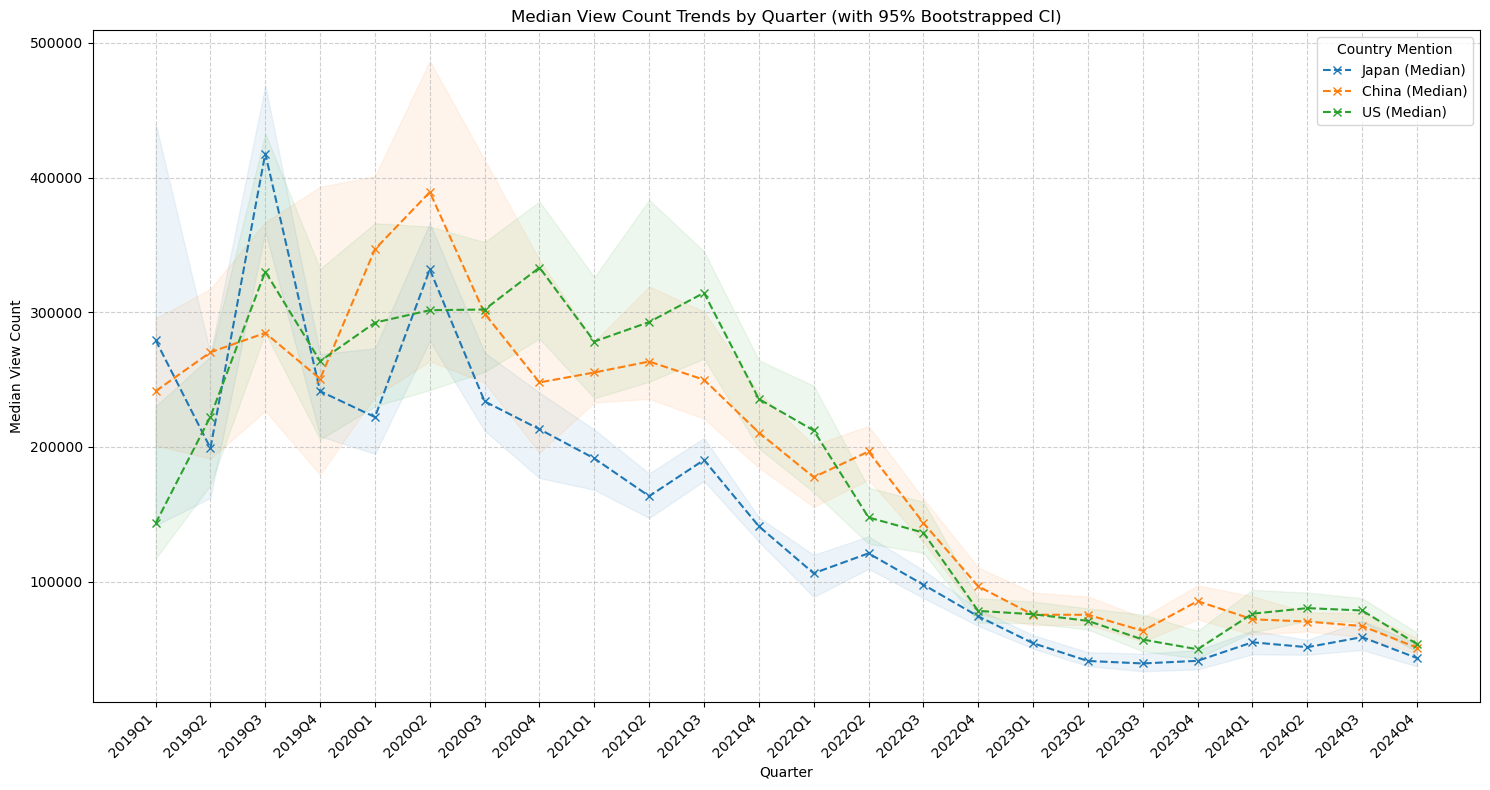

In [140]:
plot_metric(full_aggregated_data, 'Med', 'Median View Count', '(with 95% Bootstrapped CI)')

In [ ]:
def plot_metric(data_df, metric_base_name, y_label, title_suffix):
    """
    Plots either 'Avg' (Mean) or 'Med' (Median) metrics with their CIs.
    """
    plt.figure(figsize=(15, 8)) # Create a new figure for each plot
    
    for topic_label in unique_topics: # Loop through unique topics
        plot_type_prefix = ''
        linestyle = '-'
        marker = 'o'
        alpha_fill = 0.15 # For Mean CI
        label_suffix = '(Mean)'
        
        if metric_base_name == 'Med':
            plot_type_prefix = 'Med_'
            linestyle = '--'
            marker = 'x'
            alpha_fill = 0.08 # For Median CI
            label_suffix = '(Median)'

        avg_or_med_col = f'{topic_label}_{plot_type_prefix}{metric_base_name}_View_Count' # Using View_Count for metric
        lower_ci_col = f'{topic_label}_CI_{plot_type_prefix}View_Lower'
        upper_ci_col = f'{topic_label}_CI_{plot_type_prefix}View_Upper'

        # Check if the column exists in the DataFrame for robustness
        if avg_or_med_col in data_df.columns:
            x_values = data_df['Quarter_str'].to_numpy()
            y_values = data_df[avg_or_med_col].fillna(np.nan).to_numpy()
            lower_ci = data_df[lower_ci_col].fillna(np.nan).to_numpy()
            upper_ci = data_df[upper_ci_col].fillna(np.nan).to_numpy()

            plt.plot(x_values, y_values, marker=marker, linestyle=linestyle, label=f'{topic_label} {label_suffix}', color=topic_color_map.get(topic_label, 'gray'))
            plt.fill_between(x_values, lower_ci, upper_ci, color=topic_color_map.get(topic_label, 'gray'), alpha=alpha_fill)

    plt.title(f'{y_label} Trends by Quarter {title_suffix}')
    plt.xlabel('Quarter')
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside to prevent overlap
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() # Show each plot separately

def plot_count(data_df, y_label, title_suffix=''):
    """
    Plots the number of videos per topic.
    """
    plt.figure(figsize=(15, 8))
    for topic_label in unique_topics: # Loop through unique topics
        count_col = f'{topic_label}_Count_View_Count' # All counts are based on View Count
        
        if count_col in data_df.columns:
            x_values = data_df['Quarter_str'].to_numpy()
            y_values_count = data_df[count_col].fillna(0).to_numpy() # Fill with 0 for counts

            plt.plot(x_values, y_values_count, marker='s', linestyle=':', label=f'{topic_label} Video Count', color=topic_color_map.get(topic_label, 'gray'))

    plt.title(f'{y_label} by Quarter {title_suffix}')
    plt.xlabel('Quarter')
    plt.ylabel(y_label)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()